# Setting Up `pymer4`

This block will send `mamba` which makes it possible to install `conda` packages on Colab. It will cause the kernel to "crash" this *expected*.

After the kernel restarts run the cell below this one and you should be all set!

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


Run EITHER of the two cells below after the kernel restarts (no need to re-run the one above)

In [ ]:
# Option 1: Latest stable version
# !mamba install -q pymer4 -c ejolly -c conda-forge

In [ ]:
# Option 2: Development version from the main branch on github
!mamba install -q pymer4 -c ejolly/label/pre-release -c conda-forge

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


Then you can run the next cell to test the installation!

In [ ]:
from pymer4 import test_install

test_install()

All required R libraries found:
('lmerTest', 'emmeans', 'tidyverse', 'broom', 'broom.mixed', 'arrow', 'report')
Installation working successfully!


# Setup

In [ ]:
# Import packages
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Pymer
from pymer4.models import lmer
from pymer4.models import compare
from pymer4.io import save_model

# Set Polars to display more columns
pl.Config.set_tbl_cols(30)

polars.config.Config

# Load the data

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import dataframes
hrv_pd = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/vrtraining_data/hrv_data_colab.csv", index_col=["Unnamed: 0"])
rrv_pd = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/vrtraining_data/rrv_data_colab.csv", index_col=["Unnamed: 0"])

In [ ]:
# Reorder session variables for Baseline as reference
hrv_pd['session'] = pd.Categorical(
    hrv_pd['session'],
    categories=["Exam", 'Resting state', "Baseline"],
    ordered=True
)

rrv_pd['session'] = pd.Categorical(
    rrv_pd['session'],
    categories=["Exam", 'Resting state', "Baseline"],
    ordered=True
)


In [ ]:
# Convert to polars
hrv_data = pl.from_pandas(hrv_pd)
rrv_data = pl.from_pandas(rrv_pd)

In [ ]:
# Convert variables to categorical
cols_to_convert = ["session", "group", "instrument_type", "ID"]

hrv_data = hrv_data.with_columns([pl.col(c).cast(pl.Utf8).cast(pl.Categorical) for c in cols_to_convert])
rrv_data = rrv_data.with_columns([pl.col(c).cast(pl.Utf8).cast(pl.Categorical) for c in cols_to_convert])

# Convert gender to string and then to categorical
hrv_data = hrv_data.with_columns(pl.col("gender").cast(pl.Utf8).cast(pl.Categorical))
rrv_data = rrv_data.with_columns(pl.col("gender").cast(pl.Utf8).cast(pl.Categorical))

In [ ]:
# Inspect dataframes
print(hrv_data.head())
print(rrv_data.head())


shape: (5, 11)
┌───────┬─────────┬────────┬───────┬──────────┬──────────┬─────────┬─────────┬─────┬───────┬───────┐
│ ID    ┆ session ┆ gender ┆ group ┆ instrume ┆ HRV_SDNN ┆ HRV_SD1 ┆ HRV_LFH ┆ HR  ┆ HRmin ┆ HRmax │
│ ---   ┆ ---     ┆ ---    ┆ ---   ┆ nt_type  ┆ ---      ┆ SD2     ┆ F       ┆ --- ┆ ---   ┆ ---   │
│ cat   ┆ cat     ┆ cat    ┆ cat   ┆ ---      ┆ f64      ┆ ---     ┆ ---     ┆ i64 ┆ i64   ┆ i64   │
│       ┆         ┆        ┆       ┆ cat      ┆          ┆ f64     ┆ f64     ┆     ┆       ┆       │
╞═══════╪═════════╪════════╪═══════╪══════════╪══════════╪═════════╪═════════╪═════╪═══════╪═══════╡
│ vrt02 ┆ Exam    ┆ 1      ┆ exp   ┆ 2        ┆ 45.23521 ┆ 0.44931 ┆ 0.91599 ┆ 141 ┆ 106   ┆ 165   │
│       ┆         ┆        ┆       ┆          ┆ 3        ┆         ┆ 7       ┆     ┆       ┆       │
│ vrt03 ┆ Exam    ┆ 1      ┆ exp   ┆ 2        ┆ 18.82014 ┆ 0.39982 ┆ 0.85353 ┆ 164 ┆ 142   ┆ 178   │
│       ┆         ┆        ┆       ┆          ┆ 9        ┆         ┆ 9      

Variable coding:
- gender: 1 = male, 2 = female;
- intrument_type: 1 = breath-control, 2 = non-breath-control

# Linear Mixed-Effects Modeling

### Functions

In [ ]:
# Create reusable function for re-referencing variable levels
def set_factors(model):
  # Baseline vs Resting state, Baseline vs Exam, ctr vs exp
  model.set_factors({"session": ["Baseline", "Resting state", "Exam"]})
  model.set_factors({"group": ["ctr", "exp"]})

In [ ]:
def set_factors(model):
  model.set_factors({
    "session": ["Baseline", "Resting state", "Exam"],
    "group": ["ctr", "exp"]
      })

In [ ]:
# Create separate dataframes for each DV
def filter_df_for_dv(df: pl.DataFrame, dv: str) -> pl.DataFrame:
    # List of fixed columns + dv
    columns_to_keep = ["ID", "session", "gender", "group", "instrument_type", dv]

    # Filter the DataFrame by selecting only these columns
    filtered_df = df.select(columns_to_keep)

    return filtered_df

In [ ]:
model_hr_ii.data

ID,session,gender,group,instrument_type,HR,fitted,resid,hat,cooksd,fixed,mu,offset,sqrtXwt,sqrtrwt,weights,wtres
cat,enum,cat,enum,cat,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""vrt02""","""Exam""","""1""","""exp""","""2""",141,3.0311e-315,13.242872,0.24974,0.030079,122.916667,127.757128,0.0,1.0,1.0,1.0,13.242872
"""vrt03""","""Exam""","""1""","""exp""","""2""",164,3.1711e-315,35.666341,0.24974,0.218177,122.916667,128.333659,0.0,1.0,1.0,1.0,35.666341
"""vrt05""","""Exam""","""2""","""ctr""","""2""",91,3.1576e-315,-22.465897,0.29269,0.114147,121.354167,113.465897,0.0,1.0,1.0,1.0,-22.465897
"""vrt06""","""Exam""","""2""","""exp""","""1""",140,3.1446e-315,5.345321,0.255653,0.005097,137.354167,134.654679,0.0,1.0,1.0,1.0,5.345321
"""vrt07""","""Exam""","""2""","""exp""","""1""",87,3.0209e-315,-40.015639,0.255653,0.285618,137.354167,127.015639,0.0,1.0,1.0,1.0,-40.015639
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""vrt15""","""Resting state""","""2""","""exp""","""1""",105,4.1191e-315,8.727257,0.255653,0.013586,91.909722,96.272743,0.0,1.0,1.0,1.0,8.727257
"""vrt17""","""Resting state""","""2""","""ctr""","""2""",106,4.1191e-315,20.233071,0.29269,0.092585,83.854167,85.766929,0.0,1.0,1.0,1.0,20.233071
"""vrt18""","""Resting state""","""2""","""ctr""","""2""",91,4.1191e-315,12.439712,0.29269,0.034997,83.854167,78.560288,0.0,1.0,1.0,1.0,12.439712


In [ ]:
# Assumption checks function
def visual_check(model, dv: str):
    """
    Visual diagnostic plots for a pymer4 model.
    Args:
      model: fitted pymer4 model
      dv: dependent variable name (not directly used here but can be included for titles)
    """
    # Convert model data from polars to pandas for plotting
    df = model.data.to_pandas()

    # Extract observed and fitted values
    observed_values = df[dv]
    fitted_values = df['fitted']

    # Calculate standardized residuals
    residuals = df['resid']
    std_resids = (residuals - np.mean(residuals)) / np.std(residuals)

    # Plot 1: Observed vs Fitted
    plt.figure(figsize=(6, 4))
    sns.regplot(x=fitted_values, y=observed_values, ci=95, scatter_kws={"s": 50, "alpha": 0.6})
    plt.xlabel("Fitted Values")
    plt.ylabel("Observed Values")
    plt.title(f"Observed vs Fitted Values ({dv})")
    sns.despine()
    plt.show()

    # Plot 2: Residuals distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Residuals Distribution")
    plt.axvline(0, color="k", linestyle="--", linewidth=2)
    sns.despine()
    plt.show()

    # Plot 3: Standardized residuals vs Fitted
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=fitted_values, y=std_resids)
    plt.axhline(0, color='red', linestyle='--')
    plt.axhline(2.5, color="blue", linestyle="--")
    plt.axhline(-2.5, color="blue", linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Standardized Residuals")
    plt.title("Standardized Residuals vs Fitted values")
    sns.despine()
    plt.show()


In [ ]:
# Filter outliers
def reject_outliers(model):
    # Convert polars to pandas for easier numeric ops (optional)
    model_data_pd = model.data.to_pandas()

    # Calculate residuals and standardized residuals
    resids = model_data_pd['resid']  # check actual residual column name
    std_resids = (resids - np.mean(resids)) / np.std(resids)

    # Add standardized residuals back to pandas DF
    model_data_pd['std_resid'] = std_resids

    # Identify outliers in pandas DF
    outliers = model_data_pd[np.abs(model_data_pd['std_resid']) > 2.5]

    # Filter out outliers from the original polars DataFrame by ID
    outlier_ids = outliers['ID'].tolist()

    # Filter original polars DF
    filtered_model_data = model.data.filter(~pl.col('ID').is_in(outlier_ids))

    return filtered_model_data


## Heart rate

### Modeling

In [ ]:
hr_df = filter_df_for_dv(hrv_data, "HR")

In [ ]:
model_hr_i = lmer("HR ~ group * session + (1 | ID)",
               data=hr_df)

# Set reference level
set_factors(model_hr_i)

model_hr_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 11.5826 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 04      ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 19.2237 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 16      ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 100.333 ┆ 9.16249 ┆ 81.7160 ┆ 118.950 ┆ 10.9504 ┆ 34.1544 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 333     ┆ 6       ┆ 02      ┆ 664     ┆ 37      ┆ 36      ┆         ┆       │
│ null     ┆ groupex ┆ -2.8888 ┆ 11.8287 ┆ -26.923 ┆ 21.1459 ┆ -0.2442 ┆ 34.1544 ┆ 0.8085  ┆       │
│          ┆ p       ┆ 89      ┆ 31      ┆ 76      ┆ 82      ┆ 26      ┆ 36      ┆         ┆       │
│ null     ┆ session ┆ -11.666 ┆ 11.0988 ┆ -34.480 ┆ 11.1472 ┆ -1.0511 ┆ 26.0    ┆ 0.3029  ┆       │
│          ┆ Resting ┆ 667     ┆ 18      ┆ 614     ┆ 8       ┆ 63      ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ 25.8333 ┆ 11.0988 ┆ 3.01938 ┆ 48.6472 ┆ 2.32757 ┆ 26.0    ┆ 0.02799 ┆ *     │
│          ┆ Exam    ┆ 33      ┆ 18      ┆ 6       ┆ 8       ┆ 5       ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -1.8888 ┆ 14.3285 ┆ -31.341 ┆ 27.5637 ┆ -0.1318 ┆ 26.0    ┆ 0.8961  ┆       │
│          ┆ p:sessi ┆ 89      ┆ 12      ┆ 568     ┆ 9       ┆ 27      ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 6.05555 ┆ 14.3285 ┆ -23.397 ┆ 35.5082 ┆ 0.42262 ┆ 26.0    ┆ 0.676   ┆       │
│          ┆ p:sessi ┆ 6       ┆ 12      ┆ 123     ┆ 34      ┆ 3       ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a242aa1d0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', 

In [ ]:
model_hr_ii = lmer("HR ~ group * session + instrument_type + (1 | ID)",
                   data=hr_df)

set_factors(model_hr_ii)

model_hr_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 9.68717 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 3       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 19.2237 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 17      ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 95.5208 ┆ 9.16592 ┆ 76.8570 ┆ 114.184 ┆ 10.4213 ┆ 32.2900 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 33      ┆ 2       ┆ 35      ┆ 632     ┆ 01      ┆ 31      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ -11.666 ┆ 11.0988 ┆ -34.480 ┆ 11.1472 ┆ -1.0511 ┆ 26.0    ┆ 0.3029  ┆       │
│          ┆ Resting ┆ 667     ┆ 18      ┆ 614     ┆ 8       ┆ 63      ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ 25.8333 ┆ 11.0988 ┆ 3.01938 ┆ 48.6472 ┆ 2.32757 ┆ 26.0    ┆ 0.02799 ┆ *     │
│          ┆ Exam    ┆ 33      ┆ 18      ┆ 6       ┆ 8       ┆ 5       ┆         ┆         ┆       │
│ null     ┆ instrum ┆ 14.4375 ┆ 7.81270 ┆ -2.5849 ┆ 31.4599 ┆ 1.84795 ┆ 12.0    ┆ 0.08939 ┆ .     │
│          ┆ ent_typ ┆         ┆ 1       ┆ 14      ┆ 14      ┆ 2       ┆         ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -1.8888 ┆ 14.3285 ┆ -31.341 ┆ 27.5637 ┆ -0.1318 ┆ 26.0    ┆ 0.8961  ┆       │
│          ┆ p:sessi ┆ 89      ┆ 12      ┆ 568     ┆ 9       ┆ 27      ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 6.05555 ┆ 14.3285 ┆ -23.397 ┆ 35.5082 ┆ 0.42262 ┆ 26.0    ┆ 0.676   ┆       │
│          ┆ p:sessi ┆ 6       ┆ 12      ┆ 124     ┆ 35      ┆ 3       ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16b04550>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_labe

In [ ]:
model_hr_iii = lmer("HR ~ group * session + instrument_type + gender + (1 | ID)",
                    data=hr_df)

set_factors(model_hr_iii)

model_hr_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 10.2068 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 91      ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 19.2237 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 17      ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 99.2319 ┆ 10.7877 ┆ 76.9332 ┆ 121.530 ┆ 9.19857 ┆ 23.3301 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 44      ┆ 57      ┆ 27      ┆ 662     ┆         ┆         ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ 25.8333 ┆ 11.0988 ┆ 3.01938 ┆ 48.6472 ┆ 2.32757 ┆ 26.0    ┆ 0.02799 ┆ *     │
│          ┆ Exam    ┆ 33      ┆ 18      ┆ 6       ┆ 8       ┆ 5       ┆         ┆         ┆       │
│ null     ┆ instrum ┆ 14.4375 ┆ 7.99663 ┆ -3.1629 ┆ 32.0379 ┆ 1.80544 ┆ 11.0    ┆ 0.09842 ┆ .     │
│          ┆ ent_typ ┆         ┆ 9       ┆ 84      ┆ 84      ┆ 6       ┆         ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ gender2 ┆ -5.5666 ┆ 8.25889 ┆ -23.744 ┆ 12.6110 ┆ -0.6740 ┆ 11.0    ┆ 0.5142  ┆       │
│          ┆         ┆ 67      ┆ 3       ┆ 368     ┆ 35      ┆ 21      ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -1.8888 ┆ 14.3285 ┆ -31.341 ┆ 27.5637 ┆ -0.1318 ┆ 26.0    ┆ 0.8961  ┆       │
│          ┆ p:sessi ┆ 89      ┆ 12      ┆ 568     ┆ 9       ┆ 27      ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 6.05555 ┆ 14.3285 ┆ -23.397 ┆ 35.5082 ┆ 0.42262 ┆ 26.0    ┆ 0.676   ┆       │
│          ┆ p:sessi ┆ 6       ┆ 12      ┆ 124     ┆ 35      ┆ 3       ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a17386ad0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.

In [ ]:
compare(model_hr_i, model_hr_ii, model_hr_iii)

GT(_tbl_data=shape: (3, 10)
┌────────────┬───────────┬───────────┬──────┬───────────┬──────────┬─────┬───────────┬───────┬─────┐
│ AIC        ┆ BIC       ┆ logLik    ┆ npar ┆ -2*log(L) ┆ Chisq    ┆ Df  ┆ Pr(>Chisq ┆ stars ┆ ids │
│ ---        ┆ ---       ┆ ---       ┆ ---  ┆ ---       ┆ ---      ┆ --- ┆ )         ┆ ---   ┆ --- │
│ f64        ┆ f64       ┆ f64       ┆ i64  ┆ f64       ┆ f64      ┆ f64 ┆ ---       ┆ str   ┆ i64 │
│            ┆           ┆           ┆      ┆           ┆          ┆     ┆ str       ┆       ┆     │
╞════════════╪═══════════╪═══════════╪══════╪═══════════╪══════════╪═════╪═══════════╪═══════╪═════╡
│ 378.800844 ┆ 393.25414 ┆ -181.4004 ┆ 8    ┆ 398.36879 ┆ 0.0      ┆ 0.0 ┆           ┆       ┆ 1   │
│            ┆ 4         ┆ 22        ┆      ┆ 9         ┆          ┆     ┆           ┆       ┆     │
│ 371.636434 ┆ 387.89639 ┆ -176.8182 ┆ 9    ┆ 394.61235 ┆ 3.756446 ┆ 1.0 ┆ 0.0526    ┆ .     ┆ 2   │
│            ┆ 7         ┆ 17        ┆      ┆ 3         ┆          ┆     ┆           ┆       ┆     │
│ 367.134469 ┆ 385.20109 ┆ -173.5672 ┆ 10   ┆ 394.00529 ┆ 0.607054 ┆ 1.0 ┆ 0.436     ┆       ┆ 3   │
│            ┆ 4         ┆ 34        ┆      ┆ 8         ┆          ┆     ┆           ┆       ┆     │
└────────────┴───────────┴───────────┴──────┴───────────┴──────────┴─────┴───────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7b2a1715b1d0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a1735de50>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(HR~group*session+(1|ID))   \nModel 2: lmer(HR~group*session+instrument_type+(1|ID))   \nModel 3: lmer(HR~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a17208810>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a1731f010>, <great_tables._gt_data.FormatInfo object at 0x7b2a1731d410>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a173b1b10>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=Fa

Model iii seems to be the best model according to AIC, BIC and logLIK, but gender does not add significantly to the model's fit --> Thus we picked model ii

### Assumptions

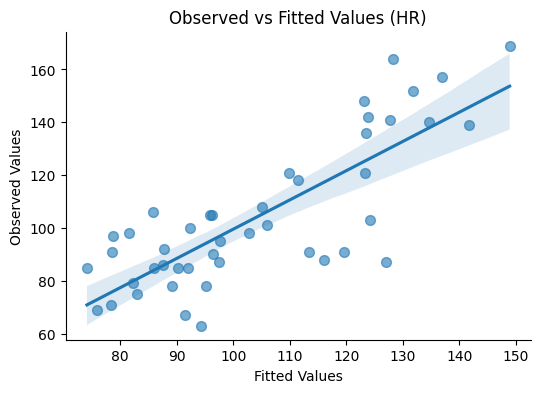

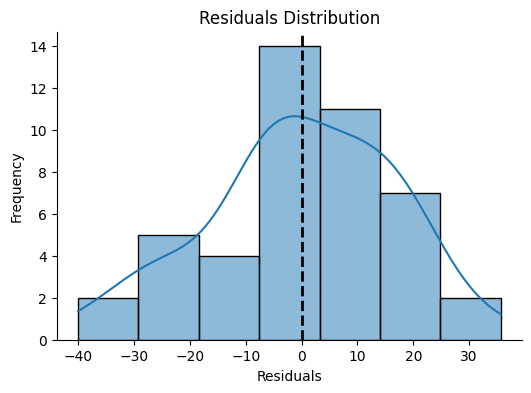

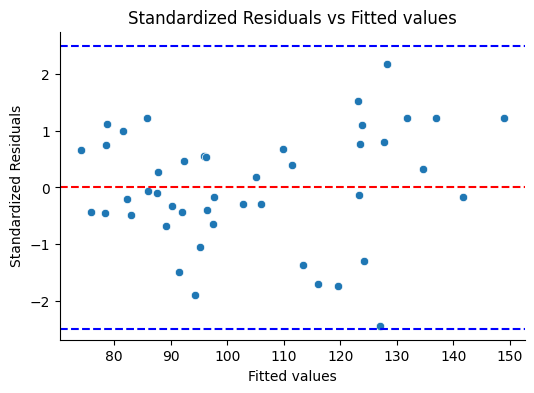

In [ ]:
# Check observed vs fitted, residuals vs frequency, residuals vs fitted plots
visual_check(model_hr_ii, dv="HR")

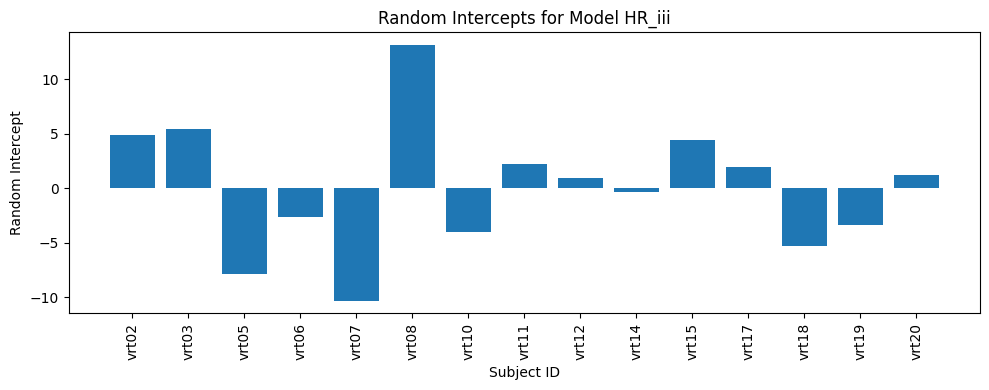

In [ ]:
# Plotting random effects -- refer to it in the main text, put it in the supplementary materials
re_df = model_hr_ii.ranef
plt.figure(figsize=(10,4))
plt.bar(re_df['level'], re_df['(Intercept)'])
plt.title('Random Intercepts for Model HR_iii')
plt.xlabel('Subject ID')
plt.ylabel('Random Intercept')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_hr = model_hr_ii.result_fit_stats
model_hr_ii.result_fit_stats

AIC,AICc,BIC,ICC,R2_conditional,R2_marginal,REMLcrit,RMSE,Sigma,df_residual,logLik,nobs,sigma
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64
371.636434,376.779291,387.896397,0.202509,0.558792,0.446755,353.636434,16.415053,19.223717,36,-176.818217,45,19.223717


In [ ]:
# Check multicollinearity
model_hr_ii.vif()

term,vif,ci_increase_factor
str,f64,f64
"""groupexp""",3.0,1.732051
"""sessionResting state""",2.666667,1.632993
"""sessionExam""",2.666667,1.632993
"""instrument_type1""",1.0,1.0
"""groupexp:sessionResting state""",3.333333,1.825742
"""groupexp:sessionExam""",3.333333,1.825742


### Post-hoc tests

In [ ]:
ph_hr = model_hr_ii.emmeans("session", contrasts="pairwise", p_adjust='bonf')
ph_hr

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""Baseline - Resting state""",12.611111,7.164256,26.0,-5.721808,30.94403,1.760282,0.270364
"""Baseline - Exam""",-28.861111,7.164256,26.0,-47.19403,-10.528192,-4.028487,0.001302
"""Resting state - Exam""",-41.472222,7.164256,26.0,-59.805141,-23.139303,-5.788769,0.000013


In [ ]:
model_hr_ii.report()

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict HR with group, session and instrument_type (formula: HR ~ group *
session + instrument_type). The model included ID as random effect (formula: ~1
| ID). The model's total explanatory power is substantial (conditional R2 =
0.56) and the part related to the fixed effects alone (marginal R2) is of 0.45.
The model's intercept, corresponding to group = ctr, session = Baseline and
instrument_type = 2, is at 95.52 (95% CI [76.93, 114.11], t(36) = 10.42, p <
.001). Within this model:

  - The effect of group [exp] is statistically non-significant and negative (beta
= -4.49, 95% CI [-27.57, 18.58], t(36) = -0.39, p = 0.695; Std. beta = -0.16,
95% CI [-0.99, 0.67])
  - The effect of session [Resting state] is statistically non-significant and
negative (beta = -11.67, 95% CI [-34.18, 10.84], t(36) = -1.05, p = 0.300; Std.
beta = -0.42, 95% CI [-1.23, 0.39])
  - The effect of session [Exam] is statistically si

## SDNN

### Modeling

In [ ]:
sdnn_df = filter_df_for_dv(hrv_data, "HRV_SDNN")

In [ ]:
model_sdnn_i = lmer("HRV_SDNN ~ group * session + (1 | ID)",
               data=sdnn_df)

# Set reference
set_factors(model_sdnn_i)

model_sdnn_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 180.988 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 734     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 123.931 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 156     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 269.566 ┆ 89.5505 ┆ 82.9084 ┆ 456.224 ┆ 3.01021 ┆ 20.2391 ┆ 0.00685 ┆ **    │
│          ┆ ept)    ┆ 321     ┆ 94      ┆ 61      ┆ 18      ┆ 3       ┆ 6       ┆ 2       ┆       │
│ null     ┆ groupex ┆ -48.269 ┆ 115.609 ┆ -289.24 ┆ 192.704 ┆ -0.4175 ┆ 20.2391 ┆ 0.6807  ┆       │
│          ┆ p       ┆ 759     ┆ 32      ┆ 4019    ┆ 501     ┆ 25      ┆ 6       ┆         ┆       │
│ null     ┆ session ┆ -146.19 ┆ 71.5516 ┆ -293.26 ┆ 0.88353 ┆ -2.0431 ┆ 26.0    ┆ 0.05129 ┆ .     │
│          ┆ Resting ┆ 3059    ┆ 87      ┆ 9657    ┆ 9       ┆ 81      ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ 84.0080 ┆ 71.5516 ┆ -63.068 ┆ 231.084 ┆ 1.17408 ┆ 26.0    ┆ 0.251   ┆       │
│          ┆ Exam    ┆ 55      ┆ 87      ┆ 543     ┆ 653     ┆ 9       ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 115.219 ┆ 92.3728 ┆ -74.655 ┆ 305.094 ┆ 1.24733 ┆ 26.0    ┆ 0.2234  ┆       │
│          ┆ p:sessi ┆ 803     ┆ 3       ┆ 268     ┆ 875     ┆ 4       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -102.64 ┆ 92.3728 ┆ -292.51 ┆ 87.2321 ┆ -1.1111 ┆ 26.0    ┆ 0.2767  ┆       │
│          ┆ p:sessi ┆ 2879    ┆ 3       ┆ 795     ┆ 93      ┆ 8       ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16749590>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', 

In [ ]:
model_sdnn_ii = lmer("HRV_SDNN ~ group * session + instrument_type + (1 | ID)",
               data=sdnn_df)

# Set reference
set_factors(model_sdnn_ii)

model_sdnn_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 187.120 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 326     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 123.931 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 156     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 287.930 ┆ 98.2327 ┆ 80.9871 ┆ 494.873 ┆ 2.93110 ┆ 17.3407 ┆ 0.00918 ┆ **    │
│          ┆ ept)    ┆ 217     ┆ 24      ┆ 12      ┆ 323     ┆ 3       ┆ 81      ┆ 3       ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ -146.19 ┆ 71.5516 ┆ -293.26 ┆ 0.88353 ┆ -2.0431 ┆ 26.0    ┆ 0.05129 ┆ .     │
│          ┆ Resting ┆ 3059    ┆ 86      ┆ 9656    ┆ 8       ┆ 81      ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ 84.0080 ┆ 71.5516 ┆ -63.068 ┆ 231.084 ┆ 1.17408 ┆ 26.0    ┆ 0.251   ┆       │
│          ┆ Exam    ┆ 55      ┆ 86      ┆ 542     ┆ 652     ┆ 9       ┆         ┆         ┆       │
│ null     ┆ instrum ┆ -55.091 ┆ 106.243 ┆ -286.57 ┆ 176.392 ┆ -0.5185 ┆ 11.9999 ┆ 0.6135  ┆       │
│          ┆ ent_typ ┆ 69      ┆ 079     ┆ 5476    ┆ 095     ┆ 44      ┆ 99      ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 115.219 ┆ 92.3728 ┆ -74.655 ┆ 305.094 ┆ 1.24733 ┆ 26.0    ┆ 0.2234  ┆       │
│          ┆ p:sessi ┆ 803     ┆ 29      ┆ 267     ┆ 874     ┆ 4       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -102.64 ┆ 92.3728 ┆ -292.51 ┆ 87.2321 ┆ -1.1111 ┆ 26.0    ┆ 0.2767  ┆       │
│          ┆ p:sessi ┆ 2879    ┆ 29      ┆ 7949    ┆ 92      ┆ 8       ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16b00e90>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_labe

In [ ]:
model_sdnn_iii = lmer("HRV_SDNN ~ group * session + instrument_type + gender + (1 | ID)",
               data=sdnn_df)

# Set reference
set_factors(model_sdnn_iii)

model_sdnn_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 145.952 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 379     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 123.931 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 156     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 128.362 ┆ 102.268 ┆ -89.054 ┆ 345.778 ┆ 1.25515 ┆ 15.4592 ┆ 0.2281  ┆       │
│          ┆ ept)    ┆ 149     ┆ 028     ┆ 384     ┆ 682     ┆ 4       ┆ 18      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ 84.0080 ┆ 71.5516 ┆ -63.068 ┆ 231.084 ┆ 1.17408 ┆ 26.0    ┆ 0.251   ┆       │
│          ┆ Exam    ┆ 55      ┆ 86      ┆ 543     ┆ 652     ┆ 9       ┆         ┆         ┆       │
│ null     ┆ instrum ┆ -55.091 ┆ 86.2039 ┆ -244.82 ┆ 134.641 ┆ -0.6390 ┆ 11.0    ┆ 0.5358  ┆       │
│          ┆ ent_typ ┆ 69      ┆ 13      ┆ 5224    ┆ 844     ┆ 86      ┆         ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ gender2 ┆ 239.352 ┆ 89.0310 ┆ 43.3961 ┆ 435.308 ┆ 2.68841 ┆ 11.0    ┆ 0.02109 ┆ *     │
│          ┆         ┆ 103     ┆ 18      ┆ 51      ┆ 054     ┆ 2       ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 115.219 ┆ 92.3728 ┆ -74.655 ┆ 305.094 ┆ 1.24733 ┆ 26.0    ┆ 0.2234  ┆       │
│          ┆ p:sessi ┆ 803     ┆ 3       ┆ 267     ┆ 874     ┆ 4       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -102.64 ┆ 92.3728 ┆ -292.51 ┆ 87.2321 ┆ -1.1111 ┆ 26.0    ┆ 0.2767  ┆       │
│          ┆ p:sessi ┆ 2879    ┆ 3       ┆ 7949    ┆ 92      ┆ 8       ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a166130d0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.

In [ ]:
compare(model_sdnn_i, model_sdnn_ii, model_sdnn_iii)

GT(_tbl_data=shape: (3, 10)
┌────────────┬───────────┬───────────┬──────┬───────────┬──────────┬─────┬───────────┬───────┬─────┐
│ AIC        ┆ BIC       ┆ logLik    ┆ npar ┆ -2*log(L) ┆ Chisq    ┆ Df  ┆ Pr(>Chisq ┆ stars ┆ ids │
│ ---        ┆ ---       ┆ ---       ┆ ---  ┆ ---       ┆ ---      ┆ --- ┆ )         ┆ ---   ┆ --- │
│ f64        ┆ f64       ┆ f64       ┆ i64  ┆ f64       ┆ f64      ┆ f64 ┆ ---       ┆ str   ┆ i64 │
│            ┆           ┆           ┆      ┆           ┆          ┆     ┆ str       ┆       ┆     │
╞════════════╪═══════════╪═══════════╪══════╪═══════════╪══════════╪═════╪═══════════╪═══════╪═════╡
│ 540.599023 ┆ 555.05232 ┆ -262.2995 ┆ 8    ┆ 585.05900 ┆ 0.0      ┆ 0.0 ┆           ┆       ┆ 1   │
│            ┆ 3         ┆ 12        ┆      ┆ 6         ┆          ┆     ┆           ┆       ┆     │
│ 531.182163 ┆ 547.44212 ┆ -256.5910 ┆ 9    ┆ 584.72660 ┆ 0.332399 ┆ 1.0 ┆ 0.564     ┆       ┆ 2   │
│            ┆ 5         ┆ 81        ┆      ┆ 7         ┆          ┆     ┆           ┆       ┆     │
│ 516.349978 ┆ 534.41660 ┆ -248.1749 ┆ 10   ┆ 577.15101 ┆ 7.575594 ┆ 1.0 ┆ 0.00592   ┆ **    ┆ 3   │
│            ┆ 3         ┆ 89        ┆      ┆ 3         ┆          ┆     ┆           ┆       ┆     │
└────────────┴───────────┴───────────┴──────┴───────────┴──────────┴─────┴───────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16713150>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a16653b90>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(HRV_SDNN~group*session+(1|ID))   \nModel 2: lmer(HRV_SDNN~group*session+instrument_type+(1|ID))   \nModel 3: lmer(HRV_SDNN~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a16c6ee90>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a165a8310>, <great_tables._gt_data.FormatInfo object at 0x7b2a16653c90>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a16652b10>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=O

Only gender has a significant addition

### Assumptions

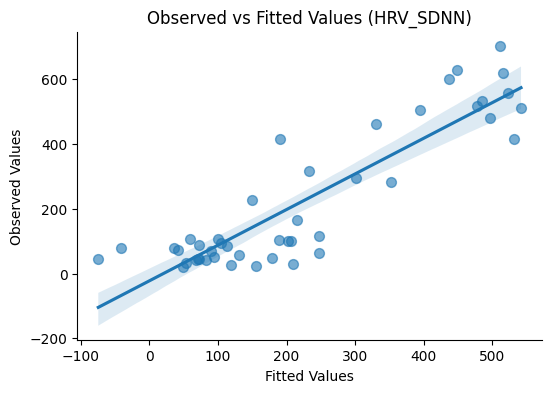

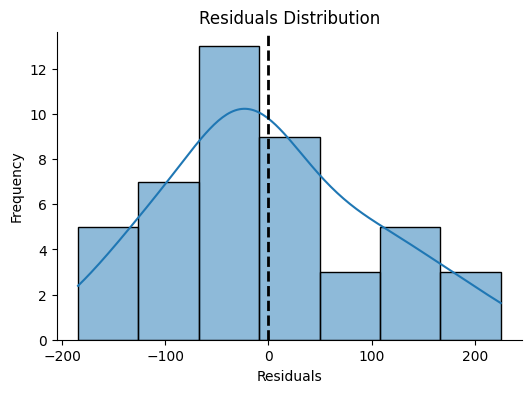

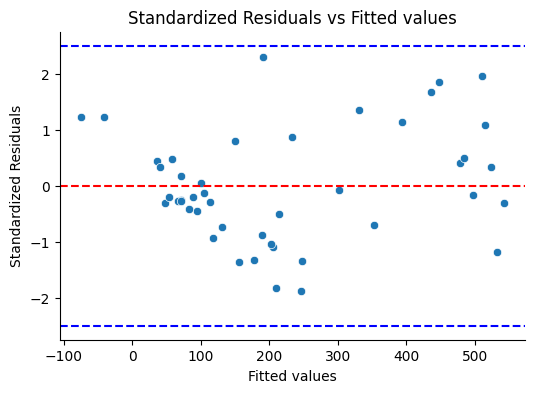

In [ ]:
# Check observed vs fitted, residuals vs frequency, residuals vs fitted plots
visual_check(model_sdnn_iii, dv="HRV_SDNN")

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_sdnn = model_sdnn_iii.result_fit_stats
model_sdnn_iii.result_fit_stats

AIC,AICc,BIC,ICC,R2_conditional,R2_marginal,REMLcrit,RMSE,Sigma,df_residual,logLik,nobs,sigma
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64
516.349978,522.820566,534.416603,0.581056,0.719187,0.329713,496.349978,97.98738,123.931156,35,-248.174989,45,123.931156


In [ ]:
# Check multicollinearity
model_sdnn_iii.vif()

term,vif,ci_increase_factor
str,f64,f64
"""groupexp""",3.0,1.732051
"""sessionResting state""",2.666667,1.632993
"""sessionExam""",2.666667,1.632993
"""instrument_type1""",1.0,1.0
"""gender2""",1.0,1.0
"""groupexp:sessionResting state""",3.333333,1.825742
"""groupexp:sessionExam""",3.333333,1.825742


### Post-hoc tests

In [ ]:
model_sdnn_iii.summary(pretty=True)

GT(_tbl_data=shape: (12, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 145.952 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 379     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 123.931 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 156     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 128.362 ┆ 102.268 ┆ -89.054 ┆ 345.778 ┆ 1.25515 ┆ 15.4592 ┆ 0.2281  ┆       │
│          ┆ ept)    ┆ 149     ┆ 028     ┆ 384     ┆ 682     ┆ 4       ┆ 18      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ 84.0080 ┆ 71.5516 ┆ -63.068 ┆ 231.084 ┆ 1.17408 ┆ 26.0    ┆ 0.251   ┆       │
│          ┆ Exam    ┆ 55      ┆ 86      ┆ 543     ┆ 652     ┆ 9       ┆         ┆         ┆       │
│ null     ┆ instrum ┆ -55.091 ┆ 86.2039 ┆ -244.82 ┆ 134.641 ┆ -0.6390 ┆ 11.0    ┆ 0.5358  ┆       │
│          ┆ ent_typ ┆ 69      ┆ 13      ┆ 5224    ┆ 844     ┆ 86      ┆         ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ gender2 ┆ 239.352 ┆ 89.0310 ┆ 43.3961 ┆ 435.308 ┆ 2.68841 ┆ 11.0    ┆ 0.02109 ┆ *     │
│          ┆         ┆ 103     ┆ 18      ┆ 51      ┆ 054     ┆ 2       ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 115.219 ┆ 92.3728 ┆ -74.655 ┆ 305.094 ┆ 1.24733 ┆ 26.0    ┆ 0.2234  ┆       │
│          ┆ p:sessi ┆ 803     ┆ 3       ┆ 267     ┆ 874     ┆ 4       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -102.64 ┆ 92.3728 ┆ -292.51 ┆ 87.2321 ┆ -1.1111 ┆ 26.0    ┆ 0.2767  ┆       │
│          ┆ p:sessi ┆ 2879    ┆ 3       ┆ 7949    ┆ 92      ┆ 8       ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16585610>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.

In [ ]:
ph_sdnn = model_sdnn_iii.emmeans("session", contrasts="pairwise", p_adjust='bonf')
ph_sdnn

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""Baseline - Resting state""",88.583157,46.186415,26.0,-29.605217,206.771532,1.917948,0.198491
"""Baseline - Exam""",-32.686615,46.186415,26.0,-150.87499,85.501759,-0.707711,1.0
"""Resting state - Exam""",-121.269773,46.186415,26.0,-239.458147,-3.081398,-2.625659,0.042894


In [ ]:
model_sdnn_iii.report()

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict HRV_SDNN with group, session, instrument_type and gender (formula:
HRV_SDNN ~ group * session + instrument_type + gender). The model included ID
as random effect (formula: ~1 | ID). The model's total explanatory power is
substantial (conditional R2 = 0.72) and the part related to the fixed effects
alone (marginal R2) is of 0.33. The model's intercept, corresponding to group =
ctr, session = Baseline, instrument_type = 2 and gender = 1, is at 128.36 (95%
CI [-79.25, 335.98], t(35) = 1.26, p = 0.218). Within this model:

  - The effect of group [exp] is statistically non-significant and negative (beta
= -42.15, 95% CI [-247.94, 163.64], t(35) = -0.42, p = 0.680; Std. beta =
-0.19, 95% CI [-1.14, 0.76])
  - The effect of session [Resting state] is statistically significant and
negative (beta = -146.19, 95% CI [-291.45, -0.94], t(35) = -2.04, p = 0.049;
Std. beta = -0.67, 95% CI [-1.35, -4.32e-03])
  -

## SD1/SD2

### Modeling

In [ ]:
sd1sd2_df = filter_df_for_dv(hrv_data, "HRV_SD1SD2")

In [ ]:
model_sd1sd2_i = lmer("HRV_SD1SD2 ~ group * session + (1 | ID)",
               data=sd1sd2_df)

# Set reference
set_factors(model_sd1sd2_i)

model_sd1sd2_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.22427 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 4       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 0.16316 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 2       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 0.51034 ┆ 0.11322 ┆ 0.27489 ┆ 0.7458  ┆ 4.50736 ┆ 21.0221 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 9       ┆ 6       ┆ 9       ┆         ┆         ┆ 39      ┆         ┆       │
│ null     ┆ groupex ┆ -0.0313 ┆ 0.14617 ┆ -0.3353 ┆ 0.27262 ┆ -0.2144 ┆ 21.0221 ┆ 0.8323  ┆       │
│          ┆ p       ┆ 44      ┆ 4       ┆ 09      ┆ 2       ┆ 27      ┆ 39      ┆         ┆       │
│ null     ┆ session ┆ -0.0088 ┆ 0.09420 ┆ -0.2025 ┆ 0.18475 ┆ -0.0942 ┆ 26.0000 ┆ 0.9256  ┆       │
│          ┆ Resting ┆ 81      ┆ 1       ┆ 15      ┆ 3       ┆ 76      ┆ 02      ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ 0.13840 ┆ 0.09420 ┆ -0.0552 ┆ 0.33203 ┆ 1.46924 ┆ 26.0000 ┆ 0.1538  ┆       │
│          ┆ Exam    ┆ 5       ┆ 1       ┆ 29      ┆ 9       ┆ 8       ┆ 02      ┆         ┆       │
│ null     ┆ groupex ┆ -0.0529 ┆ 0.12161 ┆ -0.3028 ┆ 0.19706 ┆ -0.4350 ┆ 26.0000 ┆ 0.6671  ┆       │
│          ┆ p:sessi ┆ 11      ┆ 3       ┆ 91      ┆ 9       ┆ 73      ┆ 02      ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -0.0928 ┆ 0.12161 ┆ -0.3427 ┆ 0.15716 ┆ -0.7632 ┆ 26.0000 ┆ 0.4522  ┆       │
│          ┆ p:sessi ┆ 17      ┆ 3       ┆ 97      ┆ 3       ┆ 14      ┆ 02      ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16641950>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', 

In [ ]:
model_sd1sd2_ii = lmer("HRV_SD1SD2 ~ group * session + instrument_type + (1 | ID)",
               data=sd1sd2_df)

# Set reference
set_factors(model_sd1sd2_ii)

model_sd1sd2_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.22522 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 2       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 0.16316 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 2       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 0.55145 ┆ 0.12146 ┆ 0.29650 ┆ 0.80639 ┆ 4.54002 ┆ 18.2435 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 1       ┆ 4       ┆ 8       ┆ 4       ┆ 9       ┆ 75      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ -0.0088 ┆ 0.09420 ┆ -0.2025 ┆ 0.18475 ┆ -0.0942 ┆ 26.0    ┆ 0.9256  ┆       │
│          ┆ Resting ┆ 81      ┆ 1       ┆ 15      ┆ 3       ┆ 76      ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ 0.13840 ┆ 0.09420 ┆ -0.0552 ┆ 0.33203 ┆ 1.46924 ┆ 26.0    ┆ 0.1538  ┆       │
│          ┆ Exam    ┆ 5       ┆ 1       ┆ 29      ┆ 9       ┆ 8       ┆         ┆         ┆       │
│ null     ┆ instrum ┆ -0.1233 ┆ 0.12946 ┆ -0.4053 ┆ 0.15878 ┆ -0.9523 ┆ 11.9999 ┆ 0.3597  ┆       │
│          ┆ ent_typ ┆ 05      ┆ 9       ┆ 93      ┆ 3       ┆ 94      ┆ 99      ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -0.0529 ┆ 0.12161 ┆ -0.3028 ┆ 0.19706 ┆ -0.4350 ┆ 26.0    ┆ 0.6671  ┆       │
│          ┆ p:sessi ┆ 11      ┆ 3       ┆ 91      ┆ 9       ┆ 73      ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -0.0928 ┆ 0.12161 ┆ -0.3427 ┆ 0.15716 ┆ -0.7632 ┆ 26.0    ┆ 0.4522  ┆       │
│          ┆ p:sessi ┆ 17      ┆ 3       ┆ 97      ┆ 3       ┆ 14      ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16394550>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_labe

In [ ]:
model_sd1sd2_iii = lmer("HRV_SD1SD2 ~ group * session + instrument_type + gender + (1 | ID)",
               data=sd1sd2_df)

# Set reference
set_factors(model_sd1sd2_iii)

model_sd1sd2_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.14522 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 2       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 0.16316 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 2       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 0.32470 ┆ 0.11350 ┆ 0.08611 ┆ 0.56330 ┆ 2.86075 ┆ 17.8622 ┆ 0.01045 ┆ *     │
│          ┆ ept)    ┆ 9       ┆ 5       ┆ 3       ┆ 6       ┆ 7       ┆ 64      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ 0.13840 ┆ 0.09420 ┆ -0.0552 ┆ 0.33203 ┆ 1.46924 ┆ 26.0    ┆ 0.1538  ┆       │
│          ┆ Exam    ┆ 5       ┆ 1       ┆ 29      ┆ 9       ┆ 8       ┆         ┆         ┆       │
│ null     ┆ instrum ┆ -0.1233 ┆ 0.0918  ┆ -0.3253 ┆ 0.07874 ┆ -1.3432 ┆ 10.9999 ┆ 0.2063  ┆       │
│          ┆ ent_typ ┆ 05      ┆         ┆ 55      ┆ 4       ┆         ┆ 99      ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ gender2 ┆ 0.34011 ┆ 0.09481 ┆ 0.13143 ┆ 0.54878 ┆ 3.58729 ┆ 10.9999 ┆ 0.00426 ┆ **    │
│          ┆         ┆ 3       ┆         ┆ 7       ┆ 9       ┆ 8       ┆ 99      ┆ 4       ┆       │
│ null     ┆ groupex ┆ -0.0529 ┆ 0.12161 ┆ -0.3028 ┆ 0.19706 ┆ -0.4350 ┆ 26.0    ┆ 0.6671  ┆       │
│          ┆ p:sessi ┆ 11      ┆ 3       ┆ 91      ┆ 9       ┆ 73      ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -0.0928 ┆ 0.12161 ┆ -0.3427 ┆ 0.15716 ┆ -0.7632 ┆ 26.0    ┆ 0.4522  ┆       │
│          ┆ p:sessi ┆ 17      ┆ 3       ┆ 97      ┆ 3       ┆ 13      ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a163c9d10>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.

In [ ]:
compare(model_sd1sd2_i, model_sd1sd2_ii, model_sd1sd2_iii)

GT(_tbl_data=shape: (3, 10)
┌───────────┬───────────┬───────────┬──────┬───────────┬───────────┬─────┬───────────┬───────┬─────┐
│ AIC       ┆ BIC       ┆ logLik    ┆ npar ┆ -2*log(L) ┆ Chisq     ┆ Df  ┆ Pr(>Chisq ┆ stars ┆ ids │
│ ---       ┆ ---       ┆ ---       ┆ ---  ┆ ---       ┆ ---       ┆ --- ┆ )         ┆ ---   ┆ --- │
│ f64       ┆ f64       ┆ f64       ┆ i64  ┆ f64       ┆ f64       ┆ f64 ┆ ---       ┆ str   ┆ i64 │
│           ┆           ┆           ┆      ┆           ┆           ┆     ┆ str       ┆       ┆     │
╞═══════════╪═══════════╪═══════════╪══════╪═══════════╪═══════════╪═════╪═══════════╪═══════╪═════╡
│ 21.894542 ┆ 36.347842 ┆ -2.947271 ┆ 8    ┆ -13.44616 ┆ 0.0       ┆ 0.0 ┆           ┆       ┆ 1   │
│           ┆           ┆           ┆      ┆ 5         ┆           ┆     ┆           ┆       ┆     │
│ 25.238576 ┆ 41.498538 ┆ -3.619288 ┆ 9    ┆ -14.53917 ┆ 1.093011  ┆ 1.0 ┆ 0.296     ┆       ┆ 2   │
│           ┆           ┆           ┆      ┆ 6         ┆           ┆     ┆           ┆       ┆     │
│ 20.860512 ┆ 38.927137 ┆ -0.430256 ┆ 10   ┆ -26.15927 ┆ 11.620097 ┆ 1.0 ┆ <.001     ┆ ***   ┆ 3   │
│           ┆           ┆           ┆      ┆ 3         ┆           ┆     ┆           ┆       ┆     │
└───────────┴───────────┴───────────┴──────┴───────────┴───────────┴─────┴───────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7b2a163c9dd0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a163d7750>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(HRV_SD1SD2~group*session+(1|ID))   \nModel 2: lmer(HRV_SD1SD2~group*session+instrument_type+(1|ID))   \nModel 3: lmer(HRV_SD1SD2~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a163a8d50>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a163c7550>, <great_tables._gt_data.FormatInfo object at 0x7b2a163d4590>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a163d4150>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional

Only the gender is significant

### Assumptions

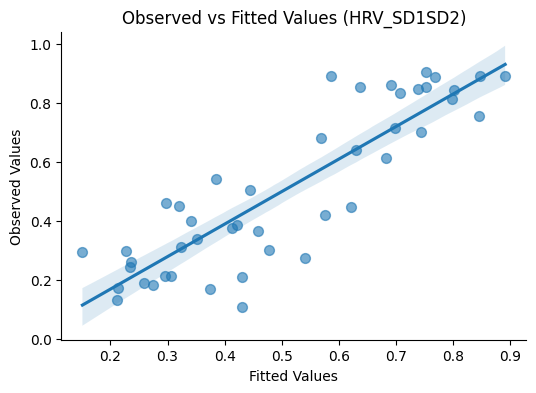

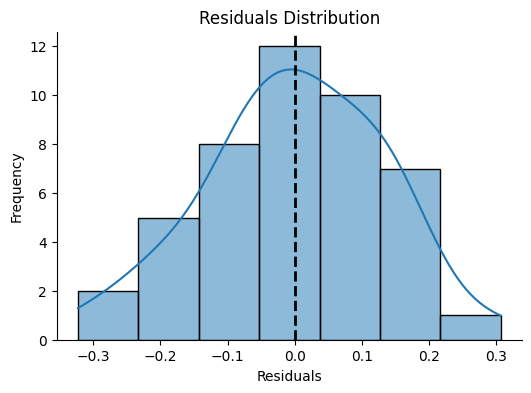

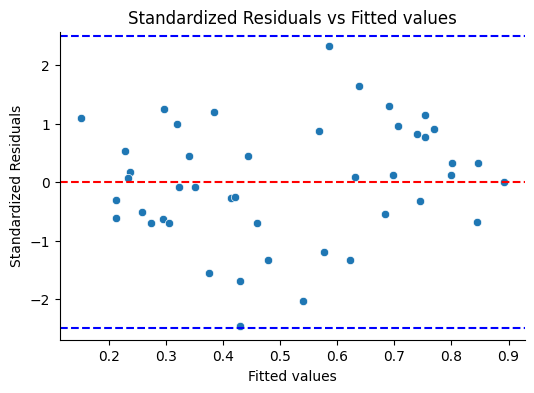

In [ ]:
# Check observed vs fitted, residuals vs frequency, residuals vs fitted plots
visual_check(model_sd1sd2_iii, dv="HRV_SD1SD2")

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_sd1sd2 = model_sdnn_iii.result_fit_stats
model_sd1sd2_iii.result_fit_stats

AIC,AICc,BIC,ICC,R2_conditional,R2_marginal,REMLcrit,RMSE,Sigma,df_residual,logLik,nobs,sigma
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64
20.860512,27.3311,38.927137,0.442023,0.676542,0.420302,0.860512,0.131563,0.163162,35,-0.430256,45,0.163162


In [ ]:
# Check multicollinearity
model_sd1sd2_iii.vif()

term,vif,ci_increase_factor
str,f64,f64
"""groupexp""",3.0,1.732051
"""sessionResting state""",2.666667,1.632993
"""sessionExam""",2.666667,1.632993
"""instrument_type1""",1.0,1.0
"""gender2""",1.0,1.0
"""groupexp:sessionResting state""",3.333333,1.825742
"""groupexp:sessionExam""",3.333333,1.825742


### Post-hoc tests

In [ ]:
model_sd1sd2_iii.summary(pretty=True)

GT(_tbl_data=shape: (12, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.14522 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 2       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 0.16316 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 2       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 0.32470 ┆ 0.11350 ┆ 0.08611 ┆ 0.56330 ┆ 2.86075 ┆ 17.8622 ┆ 0.01045 ┆ *     │
│          ┆ ept)    ┆ 9       ┆ 5       ┆ 3       ┆ 6       ┆ 7       ┆ 64      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ 0.13840 ┆ 0.09420 ┆ -0.0552 ┆ 0.33203 ┆ 1.46924 ┆ 26.0    ┆ 0.1538  ┆       │
│          ┆ Exam    ┆ 5       ┆ 1       ┆ 29      ┆ 9       ┆ 8       ┆         ┆         ┆       │
│ null     ┆ instrum ┆ -0.1233 ┆ 0.0918  ┆ -0.3253 ┆ 0.07874 ┆ -1.3432 ┆ 10.9999 ┆ 0.2063  ┆       │
│          ┆ ent_typ ┆ 05      ┆         ┆ 55      ┆ 4       ┆         ┆ 99      ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ gender2 ┆ 0.34011 ┆ 0.09481 ┆ 0.13143 ┆ 0.54878 ┆ 3.58729 ┆ 10.9999 ┆ 0.00426 ┆ **    │
│          ┆         ┆ 3       ┆         ┆ 7       ┆ 9       ┆ 8       ┆ 99      ┆ 4       ┆       │
│ null     ┆ groupex ┆ -0.0529 ┆ 0.12161 ┆ -0.3028 ┆ 0.19706 ┆ -0.4350 ┆ 26.0    ┆ 0.6671  ┆       │
│          ┆ p:sessi ┆ 11      ┆ 3       ┆ 91      ┆ 9       ┆ 73      ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -0.0928 ┆ 0.12161 ┆ -0.3427 ┆ 0.15716 ┆ -0.7632 ┆ 26.0    ┆ 0.4522  ┆       │
│          ┆ p:sessi ┆ 17      ┆ 3       ┆ 97      ┆ 3       ┆ 13      ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a163d5990>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.

Only gender has a significant main effect --> post-hoc is the output of model summary

In [ ]:
model_sd1sd2_iii.report()

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict HRV_SD1SD2 with group, session, instrument_type and gender (formula:
HRV_SD1SD2 ~ group * session + instrument_type + gender). The model included ID
as random effect (formula: ~1 | ID). The model's total explanatory power is
substantial (conditional R2 = 0.68) and the part related to the fixed effects
alone (marginal R2) is of 0.42. The model's intercept, corresponding to group =
ctr, session = Baseline, instrument_type = 2 and gender = 1, is at 0.32 (95% CI
[0.09, 0.56], t(35) = 2.86, p = 0.007). Within this model:

  - The effect of group [exp] is statistically non-significant and negative (beta
= -0.02, 95% CI [-0.25, 0.22], t(35) = -0.15, p = 0.880; Std. beta = -0.07, 95%
CI [-0.93, 0.80])
  - The effect of session [Resting state] is statistically non-significant and
negative (beta = -8.88e-03, 95% CI [-0.20, 0.18], t(35) = -0.09, p = 0.925;
Std. beta = -0.03, 95% CI [-0.74, 0.68])
  - The effe

## HRV LFHF

### Modeling

In [ ]:
hrv_lfhf_df = filter_df_for_dv(hrv_data, "HRV_LFHF")

In [ ]:
model_hrv_lfhf_i = lmer("HRV_LFHF ~ group * session + (1 | ID)",
               data=hrv_lfhf_df)

# Set reference
set_factors(model_hrv_lfhf_i)

model_hrv_lfhf_i.fit(summary=False)

In [ ]:
model_hrv_lfhf_ii = lmer("HRV_LFHF ~ group * session + instrument_type + (1 | ID)",
               data=hrv_lfhf_df)

# Set reference
set_factors(model_hrv_lfhf_ii)

model_hrv_lfhf_ii.fit(summary=False)

In [ ]:
model_hrv_lfhf_iii = lmer("HRV_LFHF ~ group * session + instrument_type + gender + (1 | ID)",
               data=hrv_lfhf_df)

# Set reference
set_factors(model_hrv_lfhf_iii)

model_hrv_lfhf_iii.fit(summary=True)

R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.

R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.



GT(_tbl_data=shape: (12, 10)
┌──────────┬──────────┬──────────┬──────────┬─────────┬─────────┬─────────┬──────┬─────────┬───────┐
│ rfx      ┆ param    ┆ estimate ┆ std_erro ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df   ┆ p_value ┆ stars │
│ ---      ┆ ---      ┆ ---      ┆ r        ┆ w       ┆ gh      ┆ ---     ┆ ---  ┆ ---     ┆ ---   │
│ str      ┆ str      ┆ f64      ┆ ---      ┆ ---     ┆ ---     ┆ f64     ┆ f64  ┆ str     ┆ str   │
│          ┆          ┆          ┆ f64      ┆ f64     ┆ f64     ┆         ┆      ┆         ┆       │
╞══════════╪══════════╪══════════╪══════════╪═════════╪═════════╪═════════╪══════╪═════════╪═══════╡
│ ID-sd    ┆ (Interce ┆ 0.0      ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│          ┆ pt)      ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ Residual ┆ Observat ┆ 2.175572 ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│ -sd      ┆ ion      ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ null     ┆ null     ┆ null     ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│ Fixed    ┆ null     ┆ null     ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│ Effects: ┆          ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ null     ┆ (Interce ┆ 4.768501 ┆ 1.023971 ┆ 2.69374 ┆ 6.84326 ┆ 4.65687 ┆ 37.0 ┆ <.001   ┆ ***   │
│          ┆ pt)      ┆          ┆          ┆         ┆ 3       ┆ 3       ┆      ┆         ┆       │
│ …        ┆ …        ┆ …        ┆ …        ┆ …       ┆ …       ┆ …       ┆ …    ┆ …       ┆ …     │
│ null     ┆ sessionE ┆ -2.04240 ┆ 1.256067 ┆ -4.5874 ┆ 0.50263 ┆ -1.6260 ┆ 37.0 ┆ 0.1124  ┆       │
│          ┆ xam      ┆ 2        ┆          ┆ 36      ┆ 1       ┆ 3       ┆      ┆         ┆       │
│ null     ┆ instrume ┆ 1.367679 ┆ 0.66613  ┆ 0.01797 ┆ 2.71738 ┆ 2.05317 ┆ 37.0 ┆ 0.04718 ┆ *     │
│          ┆ nt_type1 ┆          ┆          ┆ 2       ┆ 7       ┆ 2       ┆      ┆         ┆       │
│ null     ┆ gender2  ┆ -2.15660 ┆ 0.687976 ┆ -3.5505 ┆ -0.7626 ┆ -3.1347 ┆ 37.0 ┆ 0.00336 ┆ **    │
│          ┆          ┆ 3        ┆          ┆ 75      ┆ 3       ┆ 05      ┆      ┆ 2       ┆       │
│ null     ┆ groupexp ┆ 1.270944 ┆ 1.621575 ┆ -2.0146 ┆ 4.55656 ┆ 0.78377 ┆ 37.0 ┆ 0.4382  ┆       │
│          ┆ :session ┆          ┆          ┆ 8       ┆ 8       ┆ 1       ┆      ┆         ┆       │
│          ┆ Resting  ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│          ┆ state    ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ null     ┆ groupexp ┆ 1.257885 ┆ 1.621575 ┆ -2.0277 ┆ 4.54350 ┆ 0.77571 ┆ 37.0 ┆ 0.4428  ┆       │
│          ┆ :session ┆          ┆          ┆ 39      ┆ 9       ┆ 8       ┆      ┆         ┆       │
│          ┆ Exam     ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
└──────────┴──────────┴──────────┴──────────┴─────────┴─────────┴─────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16404a50>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), C

Last model with gender has singularity issues: random effects cannot be estimated --> last working model to interpret: model_hrv_sd1sd2_ii

In [ ]:
compare(model_hrv_lfhf_i, model_hrv_lfhf_ii)

GT(_tbl_data=shape: (2, 10)
┌────────────┬───────────┬───────────┬──────┬───────────┬──────────┬─────┬───────────┬───────┬─────┐
│ AIC        ┆ BIC       ┆ logLik    ┆ npar ┆ -2*log(L) ┆ Chisq    ┆ Df  ┆ Pr(>Chisq ┆ stars ┆ ids │
│ ---        ┆ ---       ┆ ---       ┆ ---  ┆ ---       ┆ ---      ┆ --- ┆ )         ┆ ---   ┆ --- │
│ f64        ┆ f64       ┆ f64       ┆ i64  ┆ f64       ┆ f64      ┆ f64 ┆ ---       ┆ str   ┆ i64 │
│            ┆           ┆           ┆      ┆           ┆          ┆     ┆ str       ┆       ┆     │
╞════════════╪═══════════╪═══════════╪══════╪═══════════╪══════════╪═════╪═══════════╪═══════╪═════╡
│ 209.25694  ┆ 223.71024 ┆ -96.62847 ┆ 8    ┆ 202.74121 ┆ 0.0      ┆ 0.0 ┆           ┆       ┆ 1   │
│            ┆           ┆           ┆      ┆ 7         ┆          ┆     ┆           ┆       ┆     │
│ 207.026562 ┆ 223.28652 ┆ -94.51328 ┆ 9    ┆ 199.38549 ┆ 3.355718 ┆ 1.0 ┆ 0.067     ┆ .     ┆ 2   │
│            ┆ 4         ┆ 1         ┆      ┆ 8         ┆          ┆     ┆           ┆       ┆     │
└────────────┴───────────┴───────────┴──────┴───────────┴──────────┴─────┴───────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16534e50>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a165d3390>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(HRV_LFHF~group*session+(1|ID))   \nModel 2: lmer(HRV_LFHF~group*session+instrument_type+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a164cbbd0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a163d6a90>, <great_tables._gt_data.FormatInfo object at 0x7b2a165e51d0>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a165d2dd0>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', '

### Assumptions

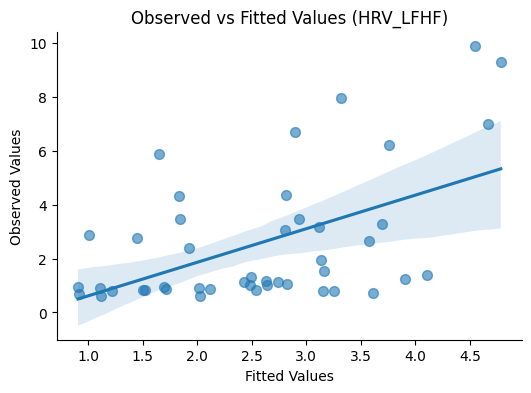

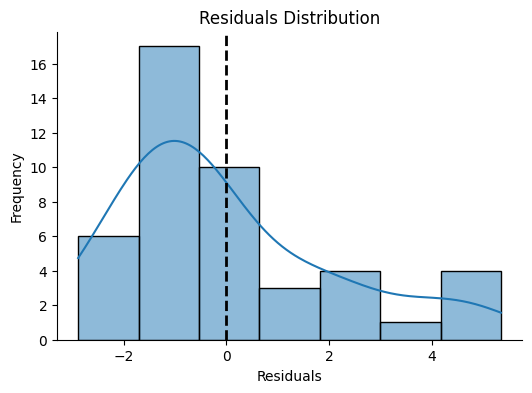

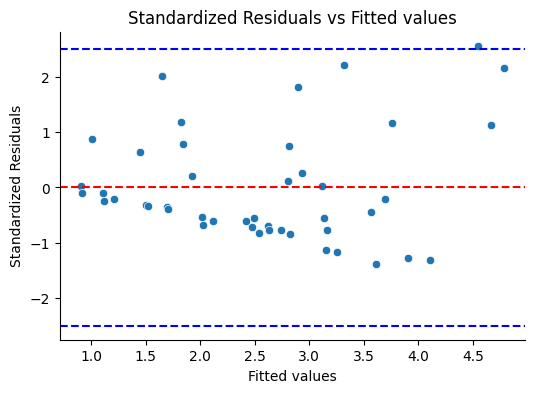

In [ ]:
# Check observed vs fitted, residuals vs frequency, residuals vs fitted plots
visual_check(model_hrv_lfhf_ii, dv="HRV_LFHF")

In [ ]:
# Reject outliers
hrv_lfhf_df_cleaned = reject_outliers(model_hrv_lfhf_ii)

# Refit the model
model_hrv_lfhf_ii_cleaned = lmer("HRV_LFHF ~ group * session + instrument_type + (1 | ID)",
               data=hrv_lfhf_df_cleaned)

# Set reference
set_factors(model_hrv_lfhf_ii_cleaned)

model_hrv_lfhf_ii_cleaned.fit(summary=True)


R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.

R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.



GT(_tbl_data=shape: (11, 10)
┌──────────┬──────────┬──────────┬──────────┬─────────┬─────────┬─────────┬──────┬─────────┬───────┐
│ rfx      ┆ param    ┆ estimate ┆ std_erro ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df   ┆ p_value ┆ stars │
│ ---      ┆ ---      ┆ ---      ┆ r        ┆ w       ┆ gh      ┆ ---     ┆ ---  ┆ ---     ┆ ---   │
│ str      ┆ str      ┆ f64      ┆ ---      ┆ ---     ┆ ---     ┆ f64     ┆ f64  ┆ str     ┆ str   │
│          ┆          ┆          ┆ f64      ┆ f64     ┆ f64     ┆         ┆      ┆         ┆       │
╞══════════╪══════════╪══════════╪══════════╪═════════╪═════════╪═════════╪══════╪═════════╪═══════╡
│ ID-sd    ┆ (Interce ┆ 0.0      ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│          ┆ pt)      ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ Residual ┆ Observat ┆ 2.207527 ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│ -sd      ┆ ion      ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ null     ┆ null     ┆ null     ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│ Fixed    ┆ null     ┆ null     ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│ Effects: ┆          ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ null     ┆ (Interce ┆ 3.511223 ┆ 0.931908 ┆ 1.61934 ┆ 5.40309 ┆ 3.76777 ┆ 35.0 ┆ <.001   ┆ ***   │
│          ┆ pt)      ┆          ┆          ┆ 9       ┆ 6       ┆ 9       ┆      ┆         ┆       │
│ …        ┆ …        ┆ …        ┆ …        ┆ …       ┆ …       ┆ …       ┆ …    ┆ …       ┆ …     │
│ null     ┆ sessionR ┆ -2.24435 ┆ 1.274516 ┆ -4.8317 ┆ 0.34304 ┆ -1.7609 ┆ 35.0 ┆ 0.08698 ┆ .     │
│          ┆ esting   ┆ 7        ┆          ┆ 63      ┆ 9       ┆ 48      ┆      ┆         ┆       │
│          ┆ state    ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ null     ┆ sessionE ┆ -2.04240 ┆ 1.274516 ┆ -4.6298 ┆ 0.54500 ┆ -1.6024 ┆ 35.0 ┆ 0.118   ┆       │
│          ┆ xam      ┆ 2        ┆          ┆ 08      ┆ 4       ┆ 92      ┆      ┆         ┆       │
│ null     ┆ instrume ┆ 0.82631  ┆ 0.71155  ┆ -0.6182 ┆ 2.27083 ┆ 1.16128 ┆ 35.0 ┆ 0.2534  ┆       │
│          ┆ nt_type1 ┆          ┆          ┆ 14      ┆ 4       ┆ 1       ┆      ┆         ┆       │
│ null     ┆ groupexp ┆ 2.055239 ┆ 1.686027 ┆ -1.3675 ┆ 5.47805 ┆ 1.21898 ┆ 35.0 ┆ 0.231   ┆       │
│          ┆ :session ┆          ┆          ┆ 77      ┆ 5       ┆ 4       ┆      ┆         ┆       │
│          ┆ Resting  ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│          ┆ state    ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ null     ┆ groupexp ┆ 1.620097 ┆ 1.686027 ┆ -1.8027 ┆ 5.04291 ┆ 0.96089 ┆ 35.0 ┆ 0.3432  ┆       │
│          ┆ :session ┆          ┆          ┆ 19      ┆ 3       ┆ 7       ┆      ┆         ┆       │
│          ┆ Exam     ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
└──────────┴──────────┴──────────┴──────────┴─────────┴─────────┴─────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a165c7450>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', 

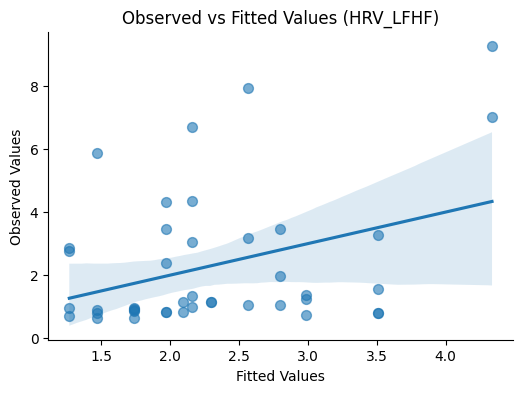

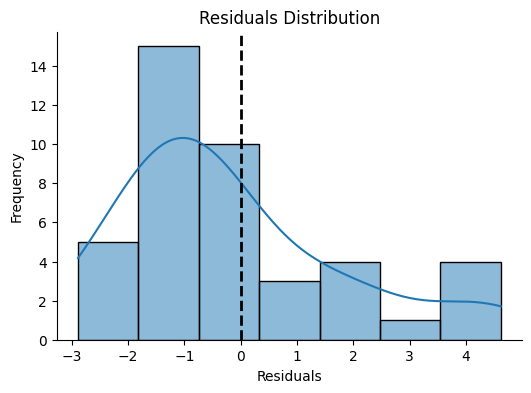

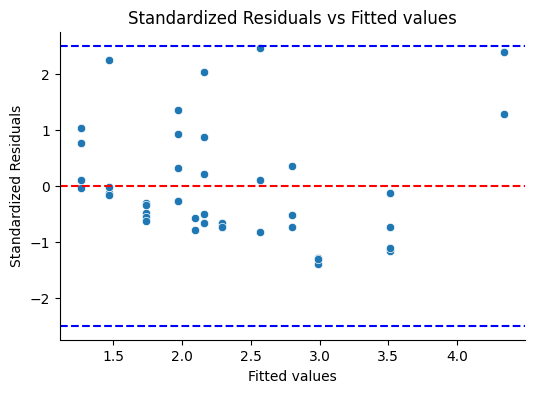

In [ ]:
visual_check(model_hrv_lfhf_ii_cleaned, dv="HRV_LFHF")

Rejecting outliers didn't lead to better results

In [ ]:
# Apply log-transformation (should I try with box-cox as well?)
hrv_lfhf_df_cleaned = hrv_lfhf_df_cleaned.with_columns(
    pl.col("HRV_LFHF").log().alias("HRV_LFHF_log"))

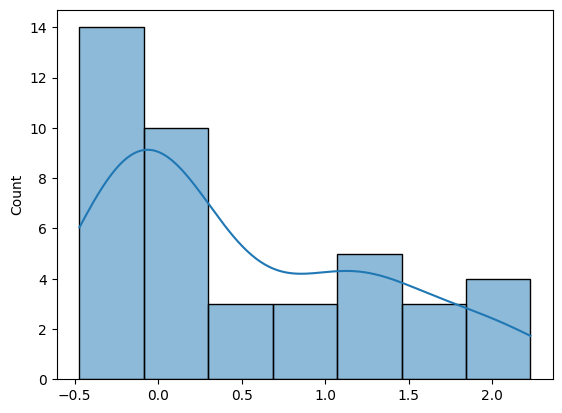

In [ ]:
# dv distribution
sns.histplot(hrv_lfhf_df_cleaned["HRV_LFHF_log"], kde=True)
plt.show()

### Refitting model

In [ ]:
model_hrv_lfhf_log_i = lmer("HRV_LFHF_log ~ group * session + (1 | ID)",
               data=hrv_lfhf_df_cleaned)

# Set reference
set_factors(model_hrv_lfhf_log_i)

model_hrv_lfhf_log_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.29539 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 1       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 0.75043 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 6       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 0.89482 ┆ 0.32924 ┆ 0.22624 ┆ 1.56339 ┆ 2.71780 ┆ 34.7491 ┆ 0.01018 ┆ *     │
│          ┆ ept)    ┆         ┆ 4       ┆ 7       ┆ 4       ┆ 1       ┆ 92      ┆         ┆       │
│ null     ┆ groupex ┆ -0.2730 ┆ 0.43554 ┆ -1.1575 ┆ 0.61136 ┆ -0.6269 ┆ 34.7491 ┆ 0.5348  ┆       │
│          ┆ p       ┆ 74      ┆ 9       ┆ 14      ┆ 6       ┆ 64      ┆ 92      ┆         ┆       │
│ null     ┆ session ┆ -0.6271 ┆ 0.43326 ┆ -1.5213 ┆ 0.26707 ┆ -1.4474 ┆ 24.0    ┆ 0.1607  ┆       │
│          ┆ Resting ┆ 37      ┆ 5       ┆ 51      ┆ 7       ┆ 69      ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ -0.6903 ┆ 0.43326 ┆ -1.5845 ┆ 0.20386 ┆ -1.5933 ┆ 24.0    ┆ 0.1242  ┆       │
│          ┆ Exam    ┆ 52      ┆ 5       ┆ 67      ┆ 2       ┆ 74      ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 0.64589 ┆ 0.57315 ┆ -0.5370 ┆ 1.82882 ┆ 1.12690 ┆ 24.0    ┆ 0.2709  ┆       │
│          ┆ p:sessi ┆ 2       ┆ 5       ┆ 41      ┆ 6       ┆ 7       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 0.36715 ┆ 0.57315 ┆ -0.8157 ┆ 1.55008 ┆ 0.64057 ┆ 24.0    ┆ 0.5279  ┆       │
│          ┆ p:sessi ┆ 1       ┆ 5       ┆ 83      ┆ 5       ┆ 8       ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a1610dd10>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', 

In [ ]:
model_hrv_lfhf_log_ii = lmer("HRV_LFHF_log ~ group * session + instrument_type + (1 | ID)",
               data=hrv_lfhf_df_cleaned)

# Set reference
set_factors(model_hrv_lfhf_log_ii)

model_hrv_lfhf_log_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.30640 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 7       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 0.75043 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 6       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 0.81116 ┆ 0.34533 ┆ 0.10706 ┆ 1.51527 ┆ 2.34890 ┆ 31.2407 ┆ 0.02533 ┆ *     │
│          ┆ ept)    ┆ 9       ┆ 9       ┆ 5       ┆ 2       ┆ 5       ┆ 88      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ -0.6271 ┆ 0.43326 ┆ -1.5213 ┆ 0.26707 ┆ -1.4474 ┆ 24.0    ┆ 0.1607  ┆       │
│          ┆ Resting ┆ 37      ┆ 5       ┆ 51      ┆ 7       ┆ 69      ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ -0.6903 ┆ 0.43326 ┆ -1.5845 ┆ 0.20386 ┆ -1.5933 ┆ 24.0    ┆ 0.1242  ┆       │
│          ┆ Exam    ┆ 52      ┆ 5       ┆ 67      ┆ 2       ┆ 74      ┆         ┆         ┆       │
│ null     ┆ instrum ┆ 0.25095 ┆ 0.29626 ┆ -0.4011 ┆ 0.90302 ┆ 0.84706 ┆ 11.0    ┆ 0.415   ┆       │
│          ┆ ent_typ ┆ 5       ┆ 4       ┆ 18      ┆ 8       ┆ 5       ┆         ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 0.64589 ┆ 0.57315 ┆ -0.5370 ┆ 1.82882 ┆ 1.12690 ┆ 24.0    ┆ 0.2709  ┆       │
│          ┆ p:sessi ┆ 2       ┆ 5       ┆ 41      ┆ 6       ┆ 7       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 0.36715 ┆ 0.57315 ┆ -0.8157 ┆ 1.55008 ┆ 0.64057 ┆ 24.0    ┆ 0.5279  ┆       │
│          ┆ p:sessi ┆ 1       ┆ 5       ┆ 83      ┆ 5       ┆ 8       ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a171b2f50>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_labe

In [ ]:
model_hrv_lfhf_log_iii = lmer("HRV_LFHF_log ~ group * session + instrument_type + gender + (1 | ID)",
               data=hrv_lfhf_df_cleaned)

# Set reference
set_factors(model_hrv_lfhf_log_iii)

model_hrv_lfhf_log_iii.fit(summary=True)

R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.

R messages: 
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.



GT(_tbl_data=shape: (12, 10)
┌──────────┬──────────┬──────────┬──────────┬─────────┬─────────┬─────────┬──────┬─────────┬───────┐
│ rfx      ┆ param    ┆ estimate ┆ std_erro ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df   ┆ p_value ┆ stars │
│ ---      ┆ ---      ┆ ---      ┆ r        ┆ w       ┆ gh      ┆ ---     ┆ ---  ┆ ---     ┆ ---   │
│ str      ┆ str      ┆ f64      ┆ ---      ┆ ---     ┆ ---     ┆ f64     ┆ f64  ┆ str     ┆ str   │
│          ┆          ┆          ┆ f64      ┆ f64     ┆ f64     ┆         ┆      ┆         ┆       │
╞══════════╪══════════╪══════════╪══════════╪═════════╪═════════╪═════════╪══════╪═════════╪═══════╡
│ ID-sd    ┆ (Interce ┆ 0.0      ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│          ┆ pt)      ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ Residual ┆ Observat ┆ 0.745867 ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│ -sd      ┆ ion      ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ null     ┆ null     ┆ null     ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│ Fixed    ┆ null     ┆ null     ┆ null     ┆ null    ┆ null    ┆ null    ┆ null ┆ null    ┆ null  │
│ Effects: ┆          ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ null     ┆ (Interce ┆ 1.237176 ┆ 0.353653 ┆ 0.51846 ┆ 1.95588 ┆ 3.49828 ┆ 34.0 ┆ 0.00132 ┆ **    │
│          ┆ pt)      ┆          ┆          ┆ 7       ┆ 5       ┆         ┆      ┆ 7       ┆       │
│ …        ┆ …        ┆ …        ┆ …        ┆ …       ┆ …       ┆ …       ┆ …    ┆ …       ┆ …     │
│ null     ┆ sessionE ┆ -0.69035 ┆ 0.430626 ┆ -1.5654 ┆ 0.18478 ┆ -1.6031 ┆ 34.0 ┆ 0.1182  ┆       │
│          ┆ xam      ┆ 2        ┆          ┆ 9       ┆ 5       ┆ 36      ┆      ┆         ┆       │
│ null     ┆ instrume ┆ 0.339706 ┆ 0.242744 ┆ -0.1536 ┆ 0.83302 ┆ 1.39944 ┆ 34.0 ┆ 0.1707  ┆       │
│          ┆ nt_type1 ┆          ┆          ┆ 08      ┆ 1       ┆ 5       ┆      ┆         ┆       │
│ null     ┆ gender2  ┆ -0.68338 ┆ 0.258309 ┆ -1.2083 ┆ -0.1584 ┆ -2.6456 ┆ 34.0 ┆ 0.01226 ┆ *     │
│          ┆          ┆ 7        ┆          ┆ 33      ┆ 41      ┆ 21      ┆      ┆         ┆       │
│ null     ┆ groupexp ┆ 0.645892 ┆ 0.569665 ┆ -0.5118 ┆ 1.80359 ┆ 1.13381 ┆ 34.0 ┆ 0.2648  ┆       │
│          ┆ :session ┆          ┆          ┆ 06      ┆ 1       ┆ 1       ┆      ┆         ┆       │
│          ┆ Resting  ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│          ┆ state    ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
│ null     ┆ groupexp ┆ 0.367151 ┆ 0.569665 ┆ -0.7905 ┆ 1.52484 ┆ 0.64450 ┆ 34.0 ┆ 0.5236  ┆       │
│          ┆ :session ┆          ┆          ┆ 48      ┆ 9       ┆ 3       ┆      ┆         ┆       │
│          ┆ Exam     ┆          ┆          ┆         ┆         ┆         ┆      ┆         ┆       │
└──────────┴──────────┴──────────┴──────────┴─────────┴─────────┴─────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a160c9d90>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), C

In [ ]:
compare(model_hrv_lfhf_log_i, model_hrv_lfhf_log_ii)

GT(_tbl_data=shape: (2, 10)
┌────────────┬───────────┬───────────┬──────┬───────────┬──────────┬─────┬───────────┬───────┬─────┐
│ AIC        ┆ BIC       ┆ logLik    ┆ npar ┆ -2*log(L) ┆ Chisq    ┆ Df  ┆ Pr(>Chisq ┆ stars ┆ ids │
│ ---        ┆ ---       ┆ ---       ┆ ---  ┆ ---       ┆ ---      ┆ --- ┆ )         ┆ ---   ┆ --- │
│ f64        ┆ f64       ┆ f64       ┆ i64  ┆ f64       ┆ f64      ┆ f64 ┆ ---       ┆ str   ┆ i64 │
│            ┆           ┆           ┆      ┆           ┆          ┆     ┆ str       ┆       ┆     │
╞════════════╪═══════════╪═══════════╪══════╪═══════════╪══════════╪═════╪═══════════╪═══════╪═════╡
│ 113.686757 ┆ 127.58811 ┆ -48.84337 ┆ 8    ┆ 93.944352 ┆ 0.0      ┆ 0.0 ┆           ┆       ┆ 1   │
│            ┆ 4         ┆ 9         ┆      ┆           ┆          ┆     ┆           ┆       ┆     │
│ 115.567747 ┆ 131.20677 ┆ -48.78387 ┆ 9    ┆ 93.059694 ┆ 0.884657 ┆ 1.0 ┆ 0.347     ┆       ┆ 2   │
│            ┆ 4         ┆ 4         ┆      ┆           ┆          ┆     ┆           ┆       ┆     │
└────────────┴───────────┴───────────┴──────┴───────────┴──────────┴─────┴───────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7b2a15dcadd0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a15e0fd10>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(HRV_LFHF_log~group*session+(1|ID))   \nModel 2: lmer(HRV_LFHF_log~group*session+instrument_type+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a15deabd0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a15f287d0>, <great_tables._gt_data.FormatInfo object at 0x7b2a15f2b910>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a15f52a50>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira 

Instrument type did not add significantly --> stay with the core model

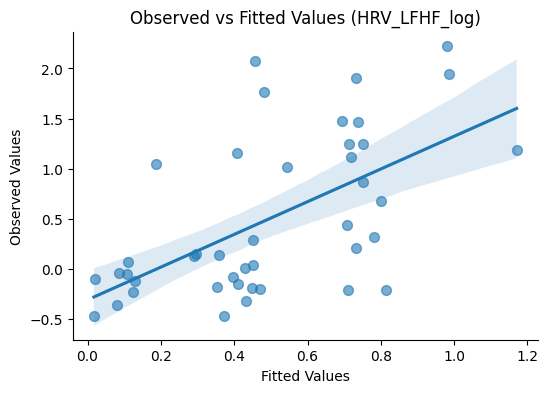

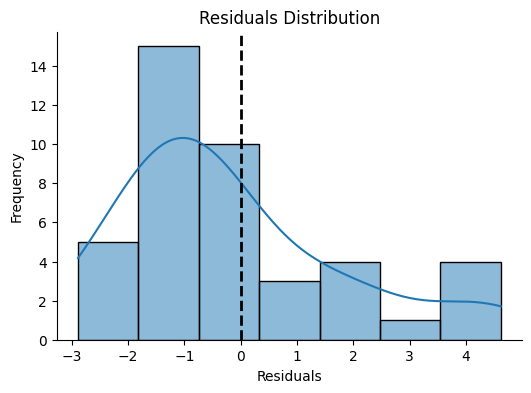

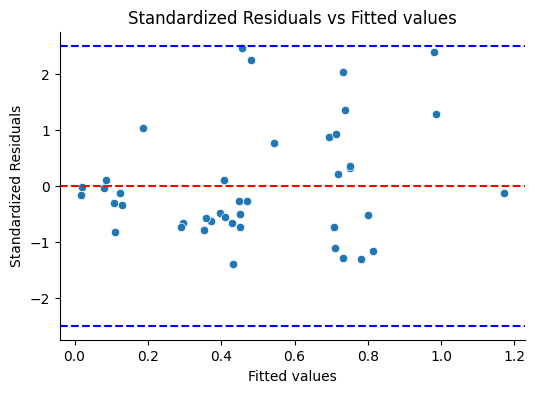

In [ ]:
visual_check(model_hrv_lfhf_log_i, dv="HRV_LFHF_log")

Its still problematic, but I will stick with this for now. No convergence or singularity issues with this model. Observed vs fitted values show the most promising results. Adding gender leads to singularity issues again. Cannot use compare() since the latest model was fitted on a filtered, thus different sized dataframe.

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_hrv_lfhf_log_df = model_hrv_lfhf_log_i.result_fit_stats
model_hrv_lfhf_log_i.result_fit_stats

AIC,AICc,BIC,ICC,R2_conditional,R2_marginal,REMLcrit,RMSE,Sigma,df_residual,logLik,nobs,sigma
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64
113.686757,118.050394,127.588114,0.134155,0.205155,0.082001,97.686757,0.656998,0.750436,34,-48.843379,42,0.750436


In [ ]:
# Check multicollinearity
model_hrv_lfhf_log.vif()

term,vif,ci_increase_factor
str,f64,f64
"""groupexp""",3.0,1.732051
"""sessionResting state""",2.666667,1.632993
"""sessionExam""",2.666667,1.632993
"""instrument_type1""",1.0,1.0
"""groupexp:sessionResting state""",3.333333,1.825742
"""groupexp:sessionExam""",3.333333,1.825742


### Post-hoc tests

We didn't find any significant effects

## Respiratory rate

### Modeling

In [ ]:
rr_df = filter_df_for_dv(rrv_data, "RSP_Rate_Mean")

In [ ]:
model_rr_i = lmer("RSP_Rate_Mean ~ group * session + (1 | ID)",
               data=rr_df)

set_factors(model_rr_i)

model_rr_i.fit(summary=True)


GT(_tbl_data=shape: (10, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 3.43215 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 6       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 4.01594 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 8       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 17.0384 ┆ 2.15667 ┆ 12.6097 ┆ 21.4671 ┆ 7.90032 ┆ 26.5421 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 38      ┆ 7       ┆ 28      ┆ 48      ┆         ┆ 67      ┆         ┆       │
│ null     ┆ groupex ┆ 2.62721 ┆ 2.85301 ┆ -3.2314 ┆ 8.48585 ┆ 0.92085 ┆ 26.5421 ┆ 0.3654  ┆       │
│          ┆ p       ┆ 9       ┆ 5       ┆ 13      ┆ 1       ┆ 7       ┆ 67      ┆         ┆       │
│ null     ┆ session ┆ -0.0974 ┆ 2.31860 ┆ -4.8828 ┆ 4.68788 ┆ -0.0420 ┆ 24.0    ┆ 0.9668  ┆       │
│          ┆ Resting ┆ 92      ┆ 8       ┆ 65      ┆ 1       ┆ 48      ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ -1.7605 ┆ 2.31860 ┆ -6.5458 ┆ 3.02485 ┆ -0.7593 ┆ 24.0    ┆ 0.4551  ┆       │
│          ┆ Exam    ┆ 2       ┆ 8       ┆ 93      ┆ 3       ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -3.7014 ┆ 3.06723 ┆ -10.031 ┆ 2.62904 ┆ -1.2067 ┆ 24.0    ┆ 0.2393  ┆       │
│          ┆ p:sessi ┆ 1       ┆ 1       ┆ 863     ┆ 3       ┆ 6       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 2.42955 ┆ 3.06723 ┆ -3.9009 ┆ 8.76000 ┆ 0.7921  ┆ 24.0    ┆ 0.4361  ┆       │
│          ┆ p:sessi ┆ 3       ┆ 1       ┆         ┆ 6       ┆         ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a15ef2bd0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', 

In [ ]:
model_rr_ii = lmer("RSP_Rate_Mean ~ group * session + instrument_type + (1 | ID)",
                   data=rr_df)

set_factors(model_rr_ii)

model_rr_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.85541 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 8       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 4.01594 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 8       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 19.2299 ┆ 1.73823 ┆ 15.6961 ┆ 22.7638 ┆ 11.0629 ┆ 33.6599 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 85      ┆ 2       ┆ 57      ┆ 13      ┆ 56      ┆ 29      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ -0.0974 ┆ 2.31860 ┆ -4.8828 ┆ 4.68788 ┆ -0.0420 ┆ 23.9999 ┆ 0.9668  ┆       │
│          ┆ Resting ┆ 92      ┆ 9       ┆ 65      ┆ 1       ┆ 48      ┆ 96      ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ -1.7605 ┆ 2.31860 ┆ -6.5458 ┆ 3.02485 ┆ -0.7593 ┆ 23.9999 ┆ 0.4551  ┆       │
│          ┆ Exam    ┆ 2       ┆ 9       ┆ 93      ┆ 3       ┆         ┆ 96      ┆         ┆       │
│ null     ┆ instrum ┆ -6.5746 ┆ 1.37974 ┆ -9.6114 ┆ -3.5378 ┆ -4.7651 ┆ 10.9999 ┆ <.001   ┆ ***   │
│          ┆ ent_typ ┆ 42      ┆ 4       ┆ 38      ┆ 45      ┆ 16      ┆ 98      ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -3.7014 ┆ 3.06723 ┆ -10.031 ┆ 2.62904 ┆ -1.2067 ┆ 23.9999 ┆ 0.2393  ┆       │
│          ┆ p:sessi ┆ 1       ┆ 1       ┆ 864     ┆ 3       ┆ 6       ┆ 96      ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 2.42955 ┆ 3.06723 ┆ -3.9009 ┆ 8.76000 ┆ 0.7921  ┆ 23.9999 ┆ 0.4361  ┆       │
│          ┆ p:sessi ┆ 3       ┆ 1       ┆         ┆ 7       ┆         ┆ 96      ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a1611b650>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_labe

In [ ]:
model_rr_iii = lmer("RSP_Rate_Mean ~ group * session + instrument_type + gender + (1 | ID)",
                    data=rr_df)

set_factors(model_rr_iii)

model_rr_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.71530 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 1       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 4.01594 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 8       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 18.1199 ┆ 1.96220 ┆ 14.0909 ┆ 22.1489 ┆ 9.23449 ┆ 26.5934 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 79      ┆ 5       ┆ 85      ┆ 74      ┆ 8       ┆ 43      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ -1.7605 ┆ 2.31860 ┆ -6.5458 ┆ 3.02485 ┆ -0.7593 ┆ 23.9999 ┆ 0.4551  ┆       │
│          ┆ Exam    ┆ 2       ┆ 9       ┆ 93      ┆ 3       ┆         ┆ 93      ┆         ┆       │
│ null     ┆ instrum ┆ -6.4699 ┆ 1.35752 ┆ -9.4946 ┆ -3.4451 ┆ -4.7659 ┆ 9.99999 ┆ <.001   ┆ ***   │
│          ┆ ent_typ ┆ 24      ┆ 2       ┆ 73      ┆ 76      ┆ 8       ┆ 5       ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ gender2 ┆ 1.61265 ┆ 1.35752 ┆ -1.4120 ┆ 4.63739 ┆ 1.18793 ┆ 9.99999 ┆ 0.2623  ┆       │
│          ┆         ┆         ┆ 2       ┆ 99      ┆ 8       ┆ 6       ┆ 5       ┆         ┆       │
│ null     ┆ groupex ┆ -3.7014 ┆ 3.06723 ┆ -10.031 ┆ 2.62904 ┆ -1.2067 ┆ 23.9999 ┆ 0.2393  ┆       │
│          ┆ p:sessi ┆ 1       ┆ 1       ┆ 864     ┆ 3       ┆ 6       ┆ 93      ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 2.42955 ┆ 3.06723 ┆ -3.9009 ┆ 8.76000 ┆ 0.7921  ┆ 23.9999 ┆ 0.4361  ┆       │
│          ┆ p:sessi ┆ 3       ┆ 1       ┆         ┆ 7       ┆         ┆ 93      ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a160159d0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.

In [ ]:
compare(model_rr_i, model_rr_ii, model_rr_iii)

GT(_tbl_data=shape: (3, 10)
┌───────────┬───────────┬───────────┬──────┬───────────┬───────────┬─────┬───────────┬───────┬─────┐
│ AIC       ┆ BIC       ┆ logLik    ┆ npar ┆ -2*log(L) ┆ Chisq     ┆ Df  ┆ Pr(>Chisq ┆ stars ┆ ids │
│ ---       ┆ ---       ┆ ---       ┆ ---  ┆ ---       ┆ ---       ┆ --- ┆ )         ┆ ---   ┆ --- │
│ f64       ┆ f64       ┆ f64       ┆ i64  ┆ f64       ┆ f64       ┆ f64 ┆ ---       ┆ str   ┆ i64 │
│           ┆           ┆           ┆      ┆           ┆           ┆     ┆ str       ┆       ┆     │
╞═══════════╪═══════════╪═══════════╪══════╪═══════════╪═══════════╪═════╪═══════════╪═══════╪═════╡
│ 243.80157 ┆ 257.70292 ┆ -113.9007 ┆ 8    ┆ 245.74496 ┆ 0.0       ┆ 0.0 ┆           ┆       ┆ 1   │
│ 1         ┆ 8         ┆ 85        ┆      ┆ 7         ┆           ┆     ┆           ┆       ┆     │
│ 229.92654 ┆ 245.56557 ┆ -105.9632 ┆ 9    ┆ 230.06790 ┆ 15.677066 ┆ 1.0 ┆ <.001     ┆ ***   ┆ 2   │
│ 9         ┆ 5         ┆ 74        ┆      ┆ 1         ┆           ┆     ┆           ┆       ┆     │
│ 228.07365 ┆ 245.45035 ┆ -104.0368 ┆ 10   ┆ 228.25835 ┆ 1.809547  ┆ 1.0 ┆ 0.179     ┆       ┆ 3   │
│ 7         ┆ 3         ┆ 28        ┆      ┆ 5         ┆           ┆     ┆           ┆       ┆     │
└───────────┴───────────┴───────────┴──────┴───────────┴───────────┴─────┴───────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7b2a15e89990>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a15ffbe50>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(RSP_Rate_Mean~group*session+(1|ID))   \nModel 2: lmer(RSP_Rate_Mean~group*session+instrument_type+(1|ID))   \nModel 3: lmer(RSP_Rate_Mean~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a15e23d50>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a15ffad90>, <great_tables._gt_data.FormatInfo object at 0x7b2a15ff9590>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a15ffb050>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_a

### Assumptions

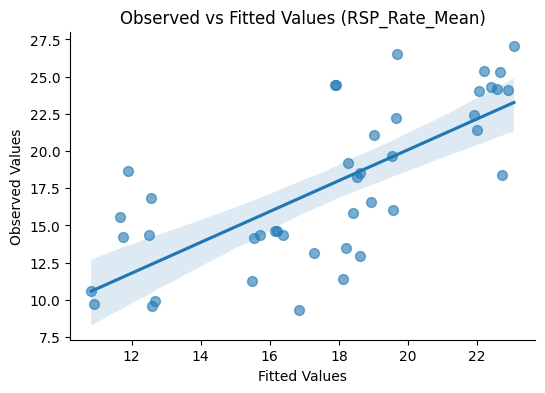

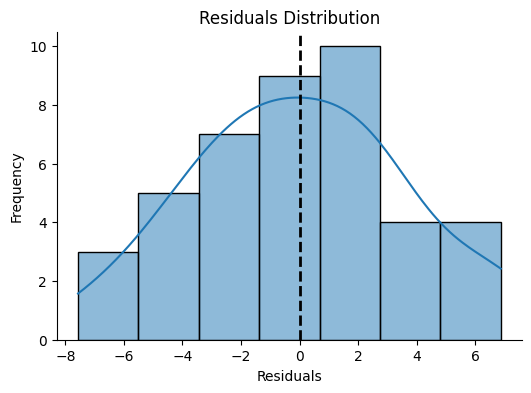

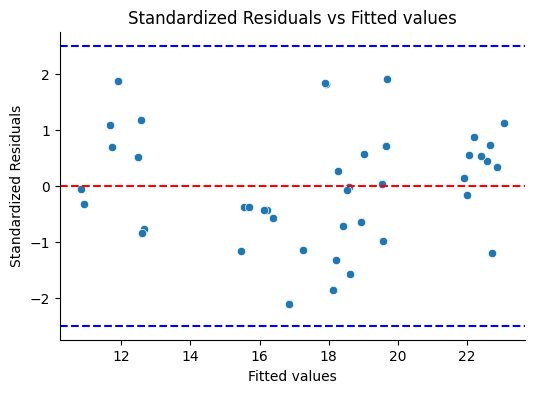

In [ ]:
visual_check(model_rr_ii, dv="RSP_Rate_Mean")

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_rr_df = model_rr_ii.result_fit_stats
model_hr_ii.result_fit_stats

AIC,AICc,BIC,ICC,R2_conditional,R2_marginal,REMLcrit,RMSE,Sigma,df_residual,logLik,nobs,sigma
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64
371.636434,376.779291,387.896397,0.202509,0.558792,0.446755,353.636434,16.415053,19.223717,36,-176.818217,45,19.223717


In [ ]:
# Check multicollinearity
model_rr_iii.vif()

term,vif,ci_increase_factor
str,f64,f64
"""groupexp""",3.0,1.732051
"""sessionResting state""",2.666667,1.632993
"""sessionExam""",2.666667,1.632993
"""instrument_type1""",1.0,1.0
"""gender2""",1.0,1.0
"""groupexp:sessionResting state""",3.333333,1.825742
"""groupexp:sessionExam""",3.333333,1.825742


### Post-hoc tests

Significant main effect in instrument type, had only two levels, look at model summary.

## SDBB

### Modeling

In [ ]:
sdbb_df = filter_df_for_dv(rrv_data, "RRV_SDBB")

In [ ]:
model_sdbb_i = lmer("RRV_SDBB ~ group * session + (1 | ID)",
               data=sdbb_df)

set_factors(model_sdbb_i)

model_sdbb_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 621.239 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 293     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 601.191 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 008     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 2067.33 ┆ 352.932 ┆ 1338.05 ┆ 2796.60 ┆ 5.85757 ┆ 23.4783 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 1225    ┆ 686     ┆ 6501    ┆ 595     ┆ 9       ┆ 19      ┆         ┆       │
│ null     ┆ groupex ┆ -326.06 ┆ 466.886 ┆ -1290.8 ┆ 638.675 ┆ -0.6983 ┆ 23.4783 ┆ 0.4918  ┆       │
│          ┆ p       ┆ 417     ┆ 059     ┆ 0395    ┆ 609     ┆ 81      ┆ 19      ┆         ┆       │
│ null     ┆ session ┆ -893.32 ┆ 347.097 ┆ -1609.7 ┆ -176.95 ┆ -2.5737 ┆ 24.0    ┆ 0.01666 ┆ *     │
│          ┆ Resting ┆ 6322    ┆ 79      ┆ 00952   ┆ 1692    ┆ 02      ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ 287.220 ┆ 347.097 ┆ -429.15 ┆ 1003.59 ┆ 0.82749 ┆ 24.0    ┆ 0.4161  ┆       │
│          ┆ Exam    ┆ 214     ┆ 79      ┆ 4416    ┆ 4844    ┆ 1       ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 592.854 ┆ 459.167 ┆ -354.82 ┆ 1540.52 ┆ 1.29115 ┆ 24.0    ┆ 0.2089  ┆       │
│          ┆ p:sessi ┆ 525     ┆ 217     ┆ 0034    ┆ 9083    ┆ 2       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -137.73 ┆ 459.167 ┆ -1085.4 ┆ 809.942 ┆ -0.2999 ┆ 24.0    ┆ 0.7668  ┆       │
│          ┆ p:sessi ┆ 2553    ┆ 217     ┆ 07111   ┆ 005     ┆ 62      ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a165efed0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', 

In [ ]:
model_sdbb_ii = lmer("RRV_SDBB ~ group * session + instrument_type + (1 | ID)",
               data=sdbb_df)

set_factors(model_sdbb_ii)

model_sdbb_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 166.030 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 359     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 601.191 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 025     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 1674.82 ┆ 264.499 ┆ 1136.75 ┆ 2212.90 ┆ 6.33206 ┆ 33.0850 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 5291    ┆ 182     ┆ 021     ┆ 0372    ┆ 2       ┆ 56      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ -893.32 ┆ 347.097 ┆ -1609.7 ┆ -176.95 ┆ -2.5737 ┆ 23.9999 ┆ 0.01666 ┆ *     │
│          ┆ Resting ┆ 6322    ┆ 8       ┆ 00977   ┆ 1667    ┆ 02      ┆ 97      ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ 287.220 ┆ 347.097 ┆ -429.15 ┆ 1003.59 ┆ 0.82749 ┆ 23.9999 ┆ 0.4161  ┆       │
│          ┆ Exam    ┆ 214     ┆ 8       ┆ 4441    ┆ 4869    ┆ 1       ┆ 97      ┆         ┆       │
│ null     ┆ instrum ┆ 1177.51 ┆ 214.809 ┆ 704.724 ┆ 1650.31 ┆ 5.48167 ┆ 10.9999 ┆ <.001   ┆ ***   │
│          ┆ ent_typ ┆ 7804    ┆ 826     ┆ 561     ┆ 1046    ┆ 6       ┆ 99      ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 592.854 ┆ 459.167 ┆ -354.82 ┆ 1540.52 ┆ 1.29115 ┆ 23.9999 ┆ 0.2089  ┆       │
│          ┆ p:sessi ┆ 525     ┆ 23      ┆ 0067    ┆ 9116    ┆ 2       ┆ 97      ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -137.73 ┆ 459.167 ┆ -1085.4 ┆ 809.942 ┆ -0.2999 ┆ 23.9999 ┆ 0.7668  ┆       │
│          ┆ p:sessi ┆ 2553    ┆ 23      ┆ 07145   ┆ 039     ┆ 62      ┆ 97      ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16ae3250>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_labe

In [ ]:
model_sdbb_iii = lmer("RRV_SDBB ~ group * session + instrument_type + gender + (1 | ID)",
               data=sdbb_df)

set_factors(model_sdbb_iii)

model_sdbb_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 190.419 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 673     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 601.191 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 012     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 1770.01 ┆ 308.144 ┆ 1134.77 ┆ 2405.26 ┆ 5.74412 ┆ 24.5377 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 9393    ┆ 496     ┆ 7201    ┆ 1585    ┆ 1       ┆ 78      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ 287.220 ┆ 347.097 ┆ -429.15 ┆ 1003.59 ┆ 0.82749 ┆ 24.0    ┆ 0.4161  ┆       │
│          ┆ Exam    ┆ 214     ┆ 793     ┆ 4421    ┆ 4849    ┆ 1       ┆         ┆         ┆       │
│ null     ┆ instrum ┆ 1168.53 ┆ 221.494 ┆ 675.016 ┆ 1662.05 ┆ 5.27569 ┆ 10.0    ┆ <.001   ┆ ***   │
│          ┆ ent_typ ┆ 7228    ┆ 488     ┆ 754     ┆ 7701    ┆ 4       ┆         ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ gender2 ┆ -138.30 ┆ 221.494 ┆ -631.82 ┆ 355.219 ┆ -0.6243 ┆ 10.0    ┆ 0.5463  ┆       │
│          ┆         ┆ 0865    ┆ 488     ┆ 1339    ┆ 608     ┆ 99      ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 592.854 ┆ 459.167 ┆ -354.82 ┆ 1540.52 ┆ 1.29115 ┆ 24.0    ┆ 0.2089  ┆       │
│          ┆ p:sessi ┆ 525     ┆ 22      ┆ 004     ┆ 909     ┆ 2       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -137.73 ┆ 459.167 ┆ -1085.4 ┆ 809.942 ┆ -0.2999 ┆ 24.0    ┆ 0.7668  ┆       │
│          ┆ p:sessi ┆ 2553    ┆ 22      ┆ 07118   ┆ 012     ┆ 62      ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a164c7690>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.

In [ ]:
compare(model_sdbb_i, model_sdbb_ii, model_sdbb_iii)

GT(_tbl_data=shape: (3, 10)
┌───────────┬───────────┬───────────┬──────┬───────────┬───────────┬─────┬───────────┬───────┬─────┐
│ AIC       ┆ BIC       ┆ logLik    ┆ npar ┆ -2*log(L) ┆ Chisq     ┆ Df  ┆ Pr(>Chisq ┆ stars ┆ ids │
│ ---       ┆ ---       ┆ ---       ┆ ---  ┆ ---       ┆ ---       ┆ --- ┆ )         ┆ ---   ┆ --- │
│ f64       ┆ f64       ┆ f64       ┆ i64  ┆ f64       ┆ f64       ┆ f64 ┆ ---       ┆ str   ┆ i64 │
│           ┆           ┆           ┆      ┆           ┆           ┆     ┆ str       ┆       ┆     │
╞═══════════╪═══════════╪═══════════╪══════╪═══════════╪═══════════╪═════╪═══════════╪═══════╪═════╡
│ 607.72967 ┆ 621.63103 ┆ -295.8648 ┆ 8    ┆ 670.32776 ┆ 0.0       ┆ 0.0 ┆           ┆       ┆ 1   │
│ 9         ┆ 6         ┆ 39        ┆      ┆           ┆           ┆     ┆           ┆       ┆     │
│ 581.39404 ┆ 597.03307 ┆ -281.6970 ┆ 9    ┆ 651.89164 ┆ 18.436117 ┆ 1.0 ┆ <.001     ┆ ***   ┆ 2   │
│ 6         ┆ 3         ┆ 23        ┆      ┆ 3         ┆           ┆     ┆           ┆       ┆     │
│ 570.38307 ┆ 587.75977 ┆ -275.1915 ┆ 10   ┆ 651.35619 ┆ 0.535452  ┆ 1.0 ┆ 0.464     ┆       ┆ 3   │
│ 4         ┆           ┆ 37        ┆      ┆ 1         ┆           ┆     ┆           ┆       ┆     │
└───────────┴───────────┴───────────┴──────┴───────────┴───────────┴─────┴───────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7b2a166535d0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a16624750>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(RRV_SDBB~group*session+(1|ID))   \nModel 2: lmer(RRV_SDBB~group*session+instrument_type+(1|ID))   \nModel 3: lmer(RRV_SDBB~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a163d6d90>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a16242290>, <great_tables._gt_data.FormatInfo object at 0x7b2a17399010>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a16447a50>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=O

### Assumptions

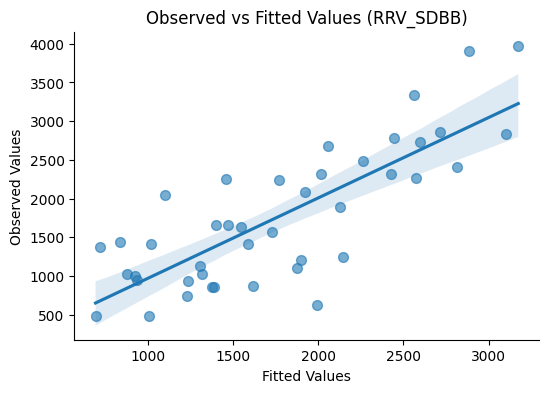

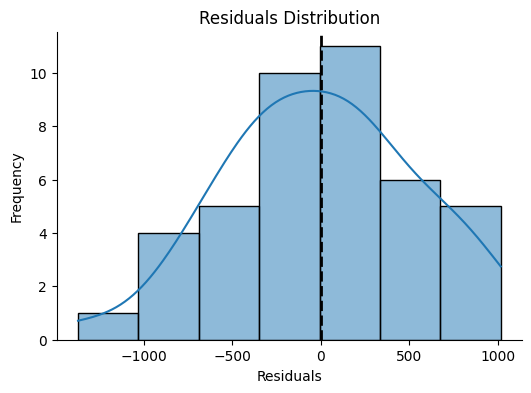

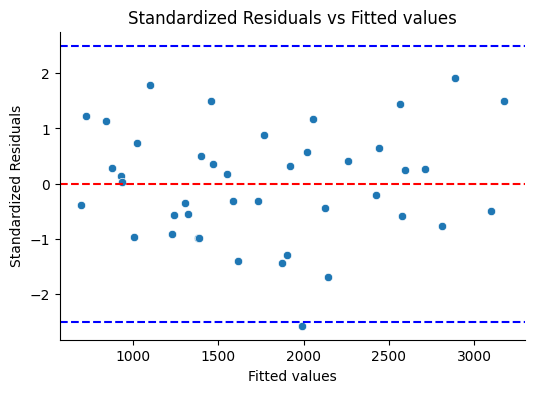

In [ ]:
visual_check(model_sdbb_ii, dv="RRV_SDBB")

One outlier, tolerable, still a very good model

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_sdbb = model_sdbb_ii.result_fit_stats
model_sdbb_ii.result_fit_stats

AIC,AICc,BIC,ICC,R2_conditional,R2_marginal,REMLcrit,RMSE,Sigma,df_residual,logLik,nobs,sigma
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64
581.394046,587.019046,597.033073,0.070865,0.576559,0.544263,563.394046,532.509277,601.191025,33,-281.697023,42,601.191025


In [ ]:
# Check multicollinearity
model_sdbb_ii.vif()

term,vif,ci_increase_factor
str,f64,f64
"""groupexp""",3.0,1.732051
"""sessionResting state""",2.666667,1.632993
"""sessionExam""",2.666667,1.632993
"""instrument_type1""",1.0,1.0
"""groupexp:sessionResting state""",3.333333,1.825742
"""groupexp:sessionExam""",3.333333,1.825742


### Post-hoc tests

In [ ]:
ph_sdbb = model_sdbb_ii.emmeans("session", contrasts="pairwise", p_adjust='bonf')
ph_sdbb

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""Baseline - Resting state""",596.899059,229.583615,23.999997,6.033246,1187.764873,2.59992,0.047122
"""Baseline - Exam""",-218.353937,229.583615,23.999997,-809.219751,372.511876,-0.951087,1.0
"""Resting state - Exam""",-815.252997,229.583615,23.999997,-1406.118811,-224.387183,-3.551007,0.004871


In [ ]:
model_sdbb_ii.report()

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict RRV_SDBB with group, session and instrument_type (formula: RRV_SDBB
~ group * session + instrument_type). The model included ID as random effect
(formula: ~1 | ID). The model's total explanatory power is substantial
(conditional R2 = 0.58) and the part related to the fixed effects alone
(marginal R2) is of 0.54. The model's intercept, corresponding to group = ctr,
session = Baseline and instrument_type = 2, is at 1674.83 (95% CI [1136.70,
2212.95], t(33) = 6.33, p < .001). Within this model:

  - The effect of group [exp] is statistically non-significant and negative (beta
= -375.13, 95% CI [-1060.66, 310.41], t(33) = -1.11, p = 0.274; Std. beta =
-0.42, 95% CI [-1.19, 0.35])
  - The effect of session [Resting state] is statistically significant and
negative (beta = -893.33, 95% CI [-1599.50, -187.15], t(33) = -2.57, p = 0.015;
Std. beta = -1.00, 95% CI [-1.79, -0.21])
  - The effect of session [Ex

## RMSSD

### Modeling

In [ ]:
rmssd_df = filter_df_for_dv(rrv_data, "RRV_RMSSD")

In [ ]:
model_rmssd_i = lmer("RRV_RMSSD ~ group * session + (1 | ID)",
               data=rmssd_df)

set_factors(model_rmssd_i)

model_rmssd_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 740.836 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 087     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 726.687 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 513     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 2623.55 ┆ 423.657 ┆ 1748.57 ┆ 3498.54 ┆ 6.19264 ┆ 23.6925 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 9315    ┆ 261     ┆ 2819    ┆ 5811    ┆ 6       ┆ 29      ┆         ┆       │
│ null     ┆ groupex ┆ -525.05 ┆ 560.445 ┆ -1682.5 ┆ 632.444 ┆ -0.9368 ┆ 23.6925 ┆ 0.3583  ┆       │
│          ┆ p       ┆ 3335    ┆ 877     ┆ 51669   ┆ 999     ┆ 49      ┆ 29      ┆         ┆       │
│ null     ┆ session ┆ -1171.9 ┆ 419.553 ┆ -2037.8 ┆ -306.04 ┆ -2.7933 ┆ 24.0    ┆ 0.01008 ┆ *     │
│          ┆ Resting ┆ 6192    ┆ 231     ┆ 7723    ┆ 661     ┆ 57      ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ 89.5485 ┆ 419.553 ┆ -776.36 ┆ 955.463 ┆ 0.21343 ┆ 24.0    ┆ 0.8328  ┆       │
│          ┆ Exam    ┆ 97      ┆ 231     ┆ 6713    ┆ 907     ┆ 8       ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 479.528 ┆ 555.016 ┆ -665.97 ┆ 1625.02 ┆ 0.86398 ┆ 24.0    ┆ 0.3961  ┆       │
│          ┆ p:sessi ┆ 15      ┆ 756     ┆ 0133    ┆ 6434    ┆ 9       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -48.489 ┆ 555.016 ┆ -1193.9 ┆ 1097.00 ┆ -0.0873 ┆ 24.0    ┆ 0.9311  ┆       │
│          ┆ p:sessi ┆ 319     ┆ 756     ┆ 87603   ┆ 8964    ┆ 66      ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a17f42990>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', 

In [ ]:
model_rmssd_ii = lmer("RRV_RMSSD ~ group * session + instrument_type + (1 | ID)",
               data=rmssd_df)

set_factors(model_rmssd_ii)

model_rmssd_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 180.928 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 944     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 726.687 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 526     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 2152.69 ┆ 317.329 ┆ 1507.34 ┆ 2798.04 ┆ 6.78377 ┆ 33.3568 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 4081    ┆ 689     ┆ 4286    ┆ 3876    ┆ 8       ┆ 94      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ -1171.9 ┆ 419.553 ┆ -2037.8 ┆ -306.04 ┆ -2.7933 ┆ 23.9999 ┆ 0.01008 ┆ *     │
│          ┆ Resting ┆ 6192    ┆ 239     ┆ 7725    ┆ 6589    ┆ 57      ┆ 98      ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ 89.5485 ┆ 419.553 ┆ -776.36 ┆ 955.463 ┆ 0.21343 ┆ 23.9999 ┆ 0.8328  ┆       │
│          ┆ Exam    ┆ 97      ┆ 239     ┆ 6734    ┆ 927     ┆ 8       ┆ 98      ┆         ┆       │
│ null     ┆ instrum ┆ 1412.59 ┆ 255.084 ┆ 851.158 ┆ 1974.03 ┆ 5.53775 ┆ 10.9999 ┆ <.001   ┆ ***   │
│          ┆ ent_typ ┆ 5701    ┆ 526     ┆ 441     ┆ 2962    ┆ 5       ┆ 99      ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 479.528 ┆ 555.016 ┆ -665.97 ┆ 1625.02 ┆ 0.86398 ┆ 23.9999 ┆ 0.3961  ┆       │
│          ┆ p:sessi ┆ 15      ┆ 766     ┆ 016     ┆ 6461    ┆ 9       ┆ 98      ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -48.489 ┆ 555.016 ┆ -1193.9 ┆ 1097.00 ┆ -0.0873 ┆ 23.9999 ┆ 0.9311  ┆       │
│          ┆ p:sessi ┆ 319     ┆ 766     ┆ 8763    ┆ 8991    ┆ 66      ┆ 98      ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a24179e90>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_labe

In [ ]:
model_rmssd_iii = lmer("RRV_RMSSD ~ group * session + instrument_type + gender + (1 | ID)",
               data=rmssd_df)

set_factors(model_rmssd_iii)

model_rmssd_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 172.313 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 27      ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 726.687 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆ 518     ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 2341.03 ┆ 361.375 ┆ 1597.95 ┆ 3084.11 ┆ 6.47811 ┆ 25.8141 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 2361    ┆ 456     ┆ 416     ┆ 0561    ┆ 7       ┆ 91      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ 89.5485 ┆ 419.553 ┆ -776.36 ┆ 955.463 ┆ 0.21343 ┆ 24.0    ┆ 0.8328  ┆       │
│          ┆ Exam    ┆ 97      ┆ 234     ┆ 672     ┆ 914     ┆ 8       ┆         ┆         ┆       │
│ null     ┆ instrum ┆ 1394.82 ┆ 253.753 ┆ 829.429 ┆ 1960.22 ┆ 5.49677 ┆ 10.0    ┆ <.001   ┆ ***   │
│          ┆ ent_typ ┆ 7939    ┆ 866     ┆ 091     ┆ 6787    ┆ 5       ┆         ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ gender2 ┆ -273.62 ┆ 253.753 ┆ -839.02 ┆ 291.775 ┆ -1.0783 ┆ 10.0    ┆ 0.3062  ┆       │
│          ┆         ┆ 3538    ┆ 866     ┆ 2387    ┆ 31      ┆ 03      ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 479.528 ┆ 555.016 ┆ -665.97 ┆ 1625.02 ┆ 0.86398 ┆ 24.0    ┆ 0.3961  ┆       │
│          ┆ p:sessi ┆ 15      ┆ 76      ┆ 0142    ┆ 6443    ┆ 9       ┆         ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ -48.489 ┆ 555.016 ┆ -1193.9 ┆ 1097.00 ┆ -0.0873 ┆ 24.0    ┆ 0.9311  ┆       │
│          ┆ p:sessi ┆ 319     ┆ 76      ┆ 87612   ┆ 8973    ┆ 66      ┆         ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16b82f90>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.

In [ ]:
compare(model_rmssd_i, model_rmssd_ii, model_rmssd_iii)

GT(_tbl_data=shape: (3, 10)
┌───────────┬───────────┬───────────┬──────┬───────────┬───────────┬─────┬───────────┬───────┬─────┐
│ AIC       ┆ BIC       ┆ logLik    ┆ npar ┆ -2*log(L) ┆ Chisq     ┆ Df  ┆ Pr(>Chisq ┆ stars ┆ ids │
│ ---       ┆ ---       ┆ ---       ┆ ---  ┆ ---       ┆ ---       ┆ --- ┆ )         ┆ ---   ┆ --- │
│ f64       ┆ f64       ┆ f64       ┆ i64  ┆ f64       ┆ f64       ┆ f64 ┆ ---       ┆ str   ┆ i64 │
│           ┆           ┆           ┆      ┆           ┆           ┆     ┆ str       ┆       ┆     │
╞═══════════╪═══════════╪═══════════╪══════╪═══════════╪═══════════╪═════╪═══════════╪═══════╪═════╡
│ 621.13321 ┆ 635.03457 ┆ -302.5666 ┆ 8    ┆ 685.96521 ┆ 0.0       ┆ 0.0 ┆           ┆       ┆ 1   │
│ 5         ┆ 2         ┆ 08        ┆      ┆ 9         ┆           ┆     ┆           ┆       ┆     │
│ 594.27459 ┆ 609.91361 ┆ -288.1372 ┆ 9    ┆ 667.31991 ┆ 18.645309 ┆ 1.0 ┆ <.001     ┆ ***   ┆ 2   │
│ 2         ┆ 8         ┆ 96        ┆      ┆           ┆           ┆     ┆           ┆       ┆     │
│ 582.20244 ┆ 599.57913 ┆ -281.1012 ┆ 10   ┆ 665.78321 ┆ 1.536691  ┆ 1.0 ┆ 0.215     ┆       ┆ 3   │
│           ┆ 6         ┆ 2         ┆      ┆ 9         ┆           ┆     ┆           ┆       ┆     │
└───────────┴───────────┴───────────┴──────┴───────────┴───────────┴─────┴───────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7b2a1639a710>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a17211f50>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(RRV_RMSSD~group*session+(1|ID))   \nModel 2: lmer(RRV_RMSSD~group*session+instrument_type+(1|ID))   \nModel 3: lmer(RRV_RMSSD~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a169c6090>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a24244210>, <great_tables._gt_data.FormatInfo object at 0x7b2a164b7f90>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a2412ff50>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_cs

### Assumptions

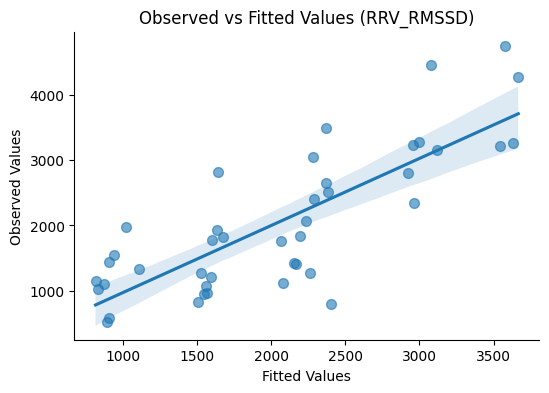

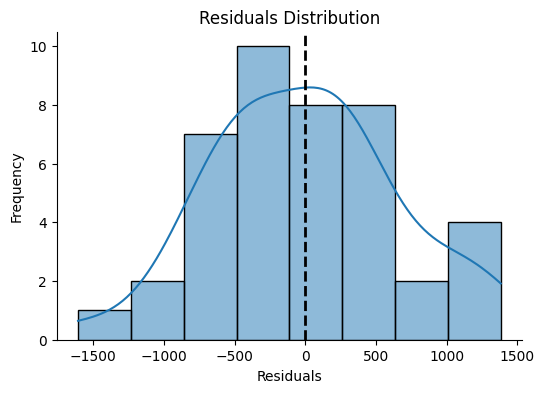

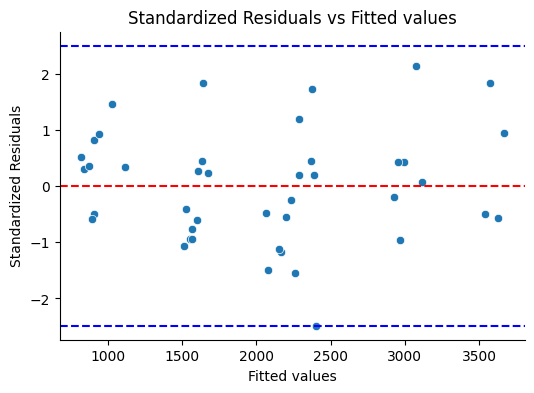

In [ ]:
# Visual check
visual_check(model_rmssd_ii, dv="RRV_RMSSD")

Again one outlier, I can keep it

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_rmssd_df = model_rmssd_ii.result_fit_stats
model_rmssd_ii.result_fit_stats

AIC,AICc,BIC,ICC,R2_conditional,R2_marginal,REMLcrit,RMSE,Sigma,df_residual,logLik,nobs,sigma
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64
594.274592,599.899592,609.913618,0.058371,0.586487,0.560853,576.274592,646.819074,726.687526,33,-288.137296,42,726.687526


In [ ]:
# Check multicollinearity
model_rmssd_ii.vif()

term,vif,ci_increase_factor
str,f64,f64
"""groupexp""",3.0,1.732051
"""sessionResting state""",2.666667,1.632993
"""sessionExam""",2.666667,1.632993
"""instrument_type1""",1.0,1.0
"""groupexp:sessionResting state""",3.333333,1.825742
"""groupexp:sessionExam""",3.333333,1.825742


### Post-hoc tests

In [ ]:
ph_rmssd = model_rmssd_ii.emmeans("session", contrasts="pairwise", p_adjust='bonf')
ph_rmssd

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""Baseline - Resting state""",932.197845,277.508383,23.999998,217.990883,1646.404806,3.35917,0.007818
"""Baseline - Exam""",-65.303937,277.508383,23.999998,-779.510899,648.903025,-0.235322,1.0
"""Resting state - Exam""",-997.501782,277.508383,23.999998,-1711.708743,-283.29482,-3.594492,0.004372


In [ ]:
model_rmssd_ii.report()

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict RRV_RMSSD with group, session and instrument_type (formula:
RRV_RMSSD ~ group * session + instrument_type). The model included ID as random
effect (formula: ~1 | ID). The model's total explanatory power is substantial
(conditional R2 = 0.59) and the part related to the fixed effects alone
(marginal R2) is of 0.56. The model's intercept, corresponding to group = ctr,
session = Baseline and instrument_type = 2, is at 2152.69 (95% CI [1507.08,
2798.31], t(33) = 6.78, p < .001). Within this model:

  - The effect of group [exp] is statistically non-significant and negative (beta
= -583.91, 95% CI [-1407.03, 239.21], t(33) = -1.44, p = 0.158; Std. beta =
-0.53, 95% CI [-1.29, 0.22])
  - The effect of session [Resting state] is statistically significant and
negative (beta = -1171.96, 95% CI [-2025.55, -318.37], t(33) = -2.79, p =
0.009; Std. beta = -1.07, 95% CI [-1.85, -0.29])
  - The effect of session 

## RRV LFHF

### Modeling

In [ ]:
rrv_lfhf_df = filter_df_for_dv(rrv_data, "RRV_LFHF")

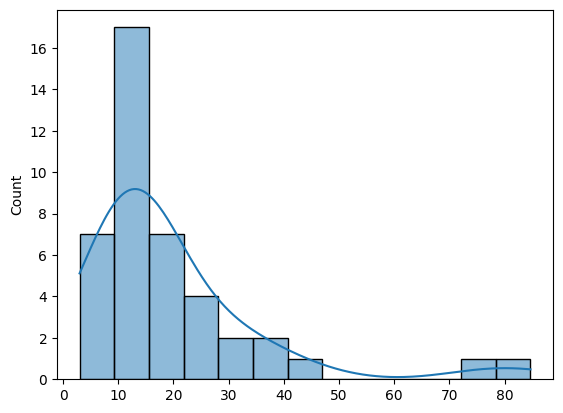

In [ ]:
# dv distribution
sns.histplot(rrv_lfhf_df["RRV_LFHF"], kde=True)
plt.show()

In [ ]:
# Apply log-transformation (should I try with box-cox as well?)
rrv_lfhf_df = rrv_lfhf_df.with_columns(
    pl.col("RRV_LFHF").log().alias("RRV_LFHF_log"))

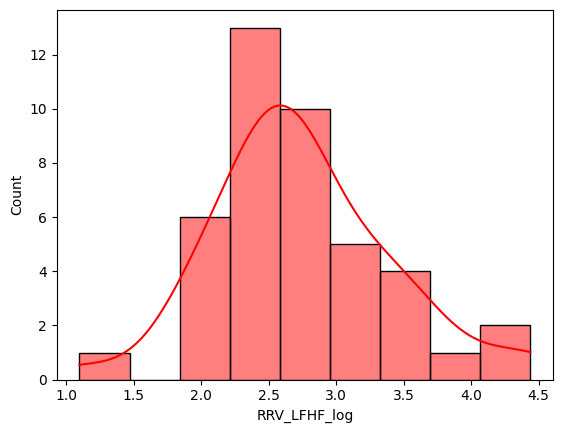

In [ ]:
# transformed dv distribution
rrv_lfhf_pandas = rrv_lfhf_df.to_pandas()

sns.histplot(rrv_lfhf_pandas["RRV_LFHF_log"], kde=True, color="red")
plt.show()

It's much better now

In [ ]:
model_rrv_lfhf_log_i = lmer("RRV_LFHF_log ~ group * session + (1 | ID)",
               data=rrv_lfhf_df)

set_factors(model_rrv_lfhf_log_i)

model_rrv_lfhf_log_i.fit(summary=True)

GT(_tbl_data=shape: (10, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.19139 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 0.59618 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 2.85557 ┆ 0.25562 ┆ 2.33683 ┆ 3.37431 ┆ 11.1710 ┆ 35.3822 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 4       ┆ 4       ┆ 1       ┆ 7       ┆ 13      ┆ 89      ┆         ┆       │
│ null     ┆ groupex ┆ -0.5314 ┆ 0.33815 ┆ -1.2176 ┆ 0.15481 ┆ -1.5715 ┆ 35.3822 ┆ 0.125   ┆       │
│          ┆ p       ┆ 22      ┆ 8       ┆ 55      ┆         ┆ 2       ┆ 89      ┆         ┆       │
│ null     ┆ session ┆ 0.14225 ┆ 0.34420 ┆ -0.5681 ┆ 0.85265 ┆ 0.41328 ┆ 23.9999 ┆ 0.6831  ┆       │
│          ┆ Resting ┆ 5       ┆ 5       ┆ 48      ┆ 8       ┆ 7       ┆ 99      ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ -0.0465 ┆ 0.34420 ┆ -0.7569 ┆ 0.66381 ┆ -0.1353 ┆ 23.9999 ┆ 0.8935  ┆       │
│          ┆ Exam    ┆ 88      ┆ 5       ┆ 92      ┆ 5       ┆ 51      ┆ 99      ┆         ┆       │
│ null     ┆ groupex ┆ 0.64848 ┆ 0.45534 ┆ -0.2912 ┆ 1.58825 ┆ 1.42417 ┆ 23.9999 ┆ 0.1673  ┆       │
│          ┆ p:sessi ┆ 3       ┆         ┆ 93      ┆ 8       ┆ 3       ┆ 99      ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 0.18342 ┆ 0.45534 ┆ -0.7563 ┆ 1.12319 ┆ 0.40282 ┆ 23.9999 ┆ 0.6906  ┆       │
│          ┆ p:sessi ┆ 4       ┆         ┆ 51      ┆ 9       ┆ 9       ┆ 99      ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a15d5e5d0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', 

In [ ]:
model_rrv_lfhf_log_ii = lmer("RRV_LFHF_log ~ group * session + instrument_type + (1 | ID)",
               data=rrv_lfhf_df)

set_factors(model_rrv_lfhf_log_ii)

model_rrv_lfhf_log_ii.fit(summary=True)

GT(_tbl_data=shape: (11, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.08187 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆ 3       ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 0.59618 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 2.72606 ┆ 0.25434 ┆ 2.20923 ┆ 3.24289 ┆ 10.7180 ┆ 34.1042 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆ 6       ┆ 4       ┆ 5       ┆ 7       ┆ 3       ┆ 07      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ 0.14225 ┆ 0.34420 ┆ -0.5681 ┆ 0.85265 ┆ 0.41328 ┆ 23.9999 ┆ 0.6831  ┆       │
│          ┆ Resting ┆ 5       ┆ 5       ┆ 48      ┆ 8       ┆ 6       ┆ 63      ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ session ┆ -0.0465 ┆ 0.34420 ┆ -0.7569 ┆ 0.66381 ┆ -0.1353 ┆ 23.9999 ┆ 0.8935  ┆       │
│          ┆ Exam    ┆ 88      ┆ 5       ┆ 92      ┆ 5       ┆ 51      ┆ 63      ┆         ┆       │
│ null     ┆ instrum ┆ 0.38852 ┆ 0.19752 ┆ -0.0462 ┆ 0.82328 ┆ 1.96693 ┆ 10.9999 ┆ 0.07492 ┆ .     │
│          ┆ ent_typ ┆ 4       ┆ 8       ┆ 31      ┆         ┆ 7       ┆ 71      ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 0.64848 ┆ 0.45534 ┆ -0.2912 ┆ 1.58825 ┆ 1.42417 ┆ 23.9999 ┆ 0.1673  ┆       │
│          ┆ p:sessi ┆ 3       ┆         ┆ 93      ┆ 8       ┆ 3       ┆ 63      ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 0.18342 ┆ 0.45534 ┆ -0.7563 ┆ 1.1232  ┆ 0.40282 ┆ 23.9999 ┆ 0.6906  ┆       │
│          ┆ p:sessi ┆ 4       ┆         ┆ 51      ┆         ┆ 9       ┆ 63      ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a2d1be110>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_labe

In [ ]:
model_rrv_lfhf_log_iii = lmer("RRV_LFHF_log ~ group * session + instrument_type + gender + (1 | ID)",
               data=rrv_lfhf_df)

set_factors(model_rrv_lfhf_log_iii)

model_rrv_lfhf_log_iii.fit(summary=True)

GT(_tbl_data=shape: (12, 10)
┌──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬───────┐
│ rfx      ┆ param   ┆ estimat ┆ std_err ┆ conf_lo ┆ conf_hi ┆ t_stat  ┆ df      ┆ p_value ┆ stars │
│ ---      ┆ ---     ┆ e       ┆ or      ┆ w       ┆ gh      ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str      ┆ str     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ f64     ┆ str     ┆ str   │
│          ┆         ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆         ┆         ┆       │
╞══════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│ ID-sd    ┆ (Interc ┆ 0.11869 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│          ┆ ept)    ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ Residual ┆ Observa ┆ 0.59618 ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ -sd      ┆ tion    ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Fixed    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null    ┆ null  │
│ Effects: ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ (Interc ┆ 2.81332 ┆ 0.29297 ┆ 2.21147 ┆ 3.41517 ┆ 9.60251 ┆ 26.3363 ┆ <.001   ┆ ***   │
│          ┆ ept)    ┆         ┆ 8       ┆         ┆         ┆ 1       ┆ 34      ┆         ┆       │
│ …        ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …       ┆ …     │
│ null     ┆ session ┆ -0.0465 ┆ 0.34420 ┆ -0.7569 ┆ 0.66381 ┆ -0.1353 ┆ 23.9999 ┆ 0.8935  ┆       │
│          ┆ Exam    ┆ 88      ┆ 5       ┆ 92      ┆ 5       ┆ 51      ┆ 99      ┆         ┆       │
│ null     ┆ instrum ┆ 0.38029 ┆ 0.2037  ┆ -0.0735 ┆ 0.83416 ┆ 1.86692 ┆ 10.0    ┆ 0.09147 ┆ .     │
│          ┆ ent_typ ┆ 3       ┆         ┆ 79      ┆ 5       ┆ 6       ┆         ┆         ┆       │
│          ┆ e1      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ gender2 ┆ -0.1267 ┆ 0.2037  ┆ -0.5806 ┆ 0.32710 ┆ -0.6223 ┆ 10.0    ┆ 0.5477  ┆       │
│          ┆         ┆ 65      ┆         ┆ 37      ┆ 6       ┆ 15      ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 0.64848 ┆ 0.45534 ┆ -0.2912 ┆ 1.58825 ┆ 1.42417 ┆ 23.9999 ┆ 0.1673  ┆       │
│          ┆ p:sessi ┆ 3       ┆         ┆ 93      ┆ 8       ┆ 3       ┆ 99      ┆         ┆       │
│          ┆ onResti ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ ng      ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│          ┆ state   ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
│ null     ┆ groupex ┆ 0.18342 ┆ 0.45534 ┆ -0.7563 ┆ 1.12319 ┆ 0.40282 ┆ 23.9999 ┆ 0.6906  ┆       │
│          ┆ p:sessi ┆ 4       ┆         ┆ 51      ┆ 9       ┆ 9       ┆ 99      ┆         ┆       │
│          ┆ onExam  ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆       │
└──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7b2a1699cd90>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.

In [ ]:
compare(model_rrv_lfhf_log_i, model_rrv_lfhf_log_ii, model_rrv_lfhf_log_iii)

GT(_tbl_data=shape: (3, 10)
┌───────────┬────────────┬───────────┬──────┬───────────┬──────────┬─────┬───────────┬───────┬─────┐
│ AIC       ┆ BIC        ┆ logLik    ┆ npar ┆ -2*log(L) ┆ Chisq    ┆ Df  ┆ Pr(>Chisq ┆ stars ┆ ids │
│ ---       ┆ ---        ┆ ---       ┆ ---  ┆ ---       ┆ ---      ┆ --- ┆ )         ┆ ---   ┆ --- │
│ f64       ┆ f64        ┆ f64       ┆ i64  ┆ f64       ┆ f64      ┆ f64 ┆ ---       ┆ str   ┆ i64 │
│           ┆            ┆           ┆      ┆           ┆          ┆     ┆ str       ┆       ┆     │
╞═══════════╪════════════╪═══════════╪══════╪═══════════╪══════════╪═════╪═══════════╪═══════╪═════╡
│ 95.770605 ┆ 109.671962 ┆ -39.88530 ┆ 8    ┆ 73.042174 ┆ 0.0      ┆ 0.0 ┆           ┆       ┆ 1   │
│           ┆            ┆ 2         ┆      ┆           ┆          ┆     ┆           ┆       ┆     │
│ 95.604149 ┆ 111.243175 ┆ -38.80207 ┆ 9    ┆ 68.827713 ┆ 4.21446  ┆ 1.0 ┆ 0.0401    ┆ *     ┆ 2   │
│           ┆            ┆ 4         ┆      ┆           ┆          ┆     ┆           ┆       ┆     │
│ 98.578937 ┆ 115.955633 ┆ -39.28946 ┆ 10   ┆ 68.313676 ┆ 0.514037 ┆ 1.0 ┆ 0.473     ┆       ┆ 3   │
│           ┆            ┆ 9         ┆      ┆           ┆          ┆     ┆           ┆       ┆     │
└───────────┴────────────┴───────────┴──────┴───────────┴──────────┴─────┴───────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x7b2a16ca68d0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7b2a15d41690>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: lmer(RRV_LFHF_log~group*session+(1|ID))   \nModel 2: lmer(RRV_LFHF_log~group*session+instrument_type+(1|ID))   \nModel 3: lmer(RRV_LFHF_log~group*session+instrument_type+gender+(1|ID))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7b2a15cd6310>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7b2a15d33e90>, <great_tables._gt_data.FormatInfo object at 0x7b2a15d30bd0>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x7b2a15d42a10>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_addi

### Assumptions

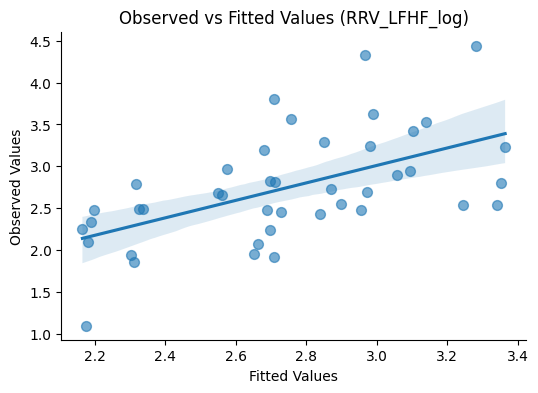

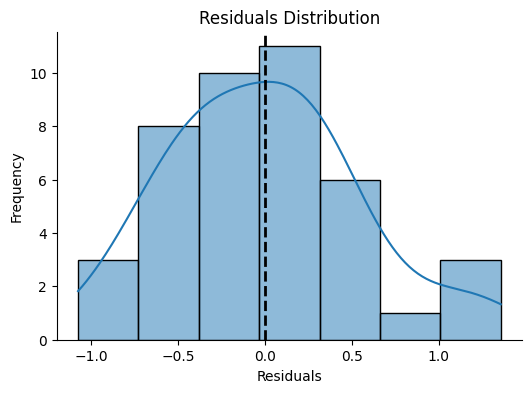

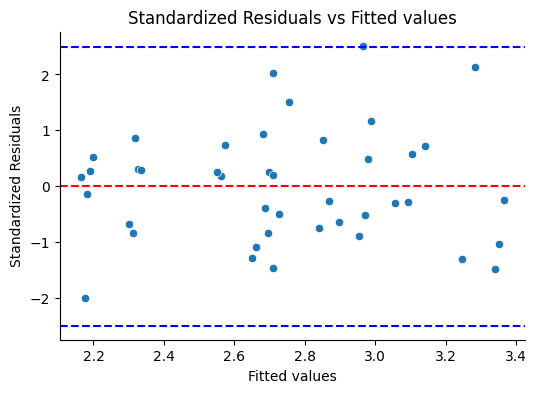

In [ ]:
visual_check(model_rrv_lfhf_log_ii, dv="RRV_LFHF_log")

### Model fit

In [ ]:
# Fitting stats and variance partitioning
model_rrv_lfhf_df = model_rrv_lfhf_log_ii.result_fit_stats
model_rrv_lfhf_log_ii.result_fit_stats

AIC,AICc,BIC,ICC,R2_conditional,R2_marginal,REMLcrit,RMSE,Sigma,df_residual,logLik,nobs,sigma
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64
95.604149,101.229149,111.243175,0.01851,0.269112,0.255328,77.604149,0.539636,0.59618,33,-38.802074,42,0.59618


In [ ]:
# Check multicollinearity
model_rrv_lfhf_log_ii.vif()

term,vif,ci_increase_factor
str,f64,f64
"""groupexp""",3.0,1.732051
"""sessionResting state""",2.666667,1.632993
"""sessionExam""",2.666667,1.632993
"""instrument_type1""",1.0,1.0
"""groupexp:sessionResting state""",3.333333,1.825742
"""groupexp:sessionExam""",3.333333,1.825742


### Post-hoc tests

There were no significant effects